# SQL Lessons
This notebook covers course material for SQL found in Udacity's Data Analyst nanodegree.

## Table of Contents
<ol>
<li><a href="#basics">SQL Basics</a></li>
<li><a href="#joins">SQL Basic Joins</a></li>
<li><a href="#agg">Aggregations</a></li>
<li><a href="#subq">Subqueries & Temporary Tables</a></li>
<li><a href="#clean">Data Cleaning</a></li>
</ol>

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine, MetaData

% matplotlib inline

In [2]:
# Create sql engine
engine = create_engine('sqlite:///parch_and_posey.db')

In [3]:
accounts = pd.read_csv('pp_accounts.txt', sep='\t')
accounts.head()

,id,name,website,lat,long,primary_poc,sales_rep_id
0,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
1,1011,Exxon Mobil,www.exxonmobil.com,41.169156,-73.849374,Sung Shields,321510
2,1021,Apple,www.apple.com,42.290495,-76.084009,Jodee Lupo,321520
3,1031,Berkshire Hathaway,www.berkshirehathaway.com,40.949021,-75.763898,Serafina Banda,321530
4,1041,McKesson,www.mckesson.com,42.217093,-75.284998,Angeles Crusoe,321540


In [6]:
# Test creation of db_name
text = 'pp.web_events.txt'
text.split('.')[1]

'web_events'

In [7]:
# Create function to read in file and save to engine
def add_to_engine(file_name):
    df = pd.read_csv(file_name, sep='\t')
    db_name = file_name.split('.')[1]
    df.to_sql(db_name, engine, index=False)

In [8]:
# Add all files to the engine
for file in glob.glob("*.txt"):
    # Manage existing names
    try:
        add_to_engine(file)
        print('Added {} to engine.'.format(file))
    except ValueError:
        continue

Added pp.accounts.txt to engine.
Added pp.orders.txt to engine.
Added pp.region.txt to engine.
Added pp.sales_reps.txt to engine.
Added pp.web_events.txt to engine.


In [31]:
conn = sqlite3.connect('parch_and_posey.db')
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS orders")
conn.commit()
conn.close()

In [33]:
file_name = 'pp.orders.txt'
df = pd.read_csv(file_name, sep='\t')
db_name = file_name.split('.')[1]
df.to_sql(db_name, engine, index=False)

In [26]:
# Replace existing orders table
conn = sqlite3.connect('parch_and_posey.db')
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS orders")
cur.execute("CREATE TABLE orders ( \
                id TEXT PRIMARY KEY, account_id TEXT, standard_qty INTEGER, poster_qty INTEGER, glossy_qty INTEGER, \
                total INTEGER, occurred_at TEXT, standard_amt_usd REAL, gloss_amt_usd REAL, poster_amt_usd REAL, total_amt_usd REAL);")

In [27]:
# Add orders values
orders = pd.read_csv('pp.orders.txt', sep='\t')

for index, values in orders.iterrows():
    id_key, account_id, standard_qty, poster_qty, gloss_qty, total, occurred_at, standard_amt_usd, gloss_amt_usd, poster_amt_usd, total_amt_usd = values
    
    sql_string = 'INSERT INTO orders (id, account_id, standard_qty, poster_qty, glossy_qty, total, occurred_at, standard_amt_usd, gloss_amt_usd, poster_amt_usd, total_amt_usd) \
                  VALUES ("{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}", "{}");'.format(
        id_key, account_id, standard_qty, poster_qty, gloss_qty, total, occurred_at, 
        standard_amt_usd, gloss_amt_usd, poster_amt_usd, total_amt_usd
    )
    cur.execute(sql_string)

conn.commit()

In [28]:
conn.close()

In [11]:
# Print schema
metadata = MetaData()
metadata.reflect(engine)
for table in metadata.tables.values():
    print('\n' + table.name)
    for column in table.c:
        print('  ' + column.name)


accounts
  id
  name
  website
  lat
  long
  primary_poc
  sales_rep_id

orders
  id
  account_id
  standard_qty
  poster_qty
  glossy_qty
  total
  occurred_at
  standard_amt_usd
  gloss_amt_usd
  poster_amt_usd
  total_amt_usd

region
  id
  name

sales_reps
  id
  name
  region_id

web_events
  id
  account_id
  occurred_at
  channel


!['ERD'](erd.PNG)

In [14]:
# Create function to speed up code
def sql_query(query_syntax):
    df = pd.read_sql(query_syntax, engine)
    return df

<a id='basics'></a>
## Lesson 1: Basic SQL
### Basic Query
Try writing your own query to select only the `id`, `account_id`, and `occurred_at` columns for all **orders** in the orders table.

In [14]:
sql_query('SELECT id, account_id, occurred_at \
           FROM orders;')

,id,account_id,occurred_at
0,1,1001,2015-10-06T17:31:14.000Z
1,2,1001,2015-11-05T03:34:33.000Z
2,3,1001,2015-12-04T04:21:55.000Z
3,4,1001,2016-01-02T01:18:24.000Z
4,5,1001,2016-02-01T19:27:27.000Z
5,6,1001,2016-03-02T15:29:32.000Z
6,7,1001,2016-04-01T11:20:18.000Z
7,8,1001,2016-05-01T15:55:51.000Z
8,9,1001,2016-05-31T21:22:48.000Z
9,10,1001,2016-06-30T12:32:05.000Z


### Limit

In [16]:
sql_query('SELECT occurred_at, account_id, channel \
           FROM web_events \
           LIMIT 15;')

,occurred_at,account_id,channel
0,2015-10-06T17:13:58.000Z,1001,direct
1,2015-11-05T03:08:26.000Z,1001,direct
2,2015-12-04T03:57:24.000Z,1001,direct
3,2016-01-02T00:55:03.000Z,1001,direct
4,2016-02-01T19:02:33.000Z,1001,direct
5,2016-03-02T15:15:22.000Z,1001,direct
6,2016-04-01T10:58:55.000Z,1001,direct
7,2016-05-01T15:26:44.000Z,1001,direct
8,2016-05-31T20:53:47.000Z,1001,direct
9,2016-06-30T12:09:45.000Z,1001,direct


### Order By
ORDER BY comes after SELECT and FROM but before LIMIT. DESC can be used to sort in descending order. 

**1** Write a query to return the 10 earliest orders in the **orders** table. Include the `id`, `occurred_at`, and `total_amt_usd`.

In [17]:
sql_query('SELECT id, occurred_at, total_amt_usd \
           FROM orders \
           ORDER BY occurred_at \
           LIMIT 10;')

,id,occurred_at,total_amt_usd
0,5786,2013-12-04T04:22:44.000Z,627.48
1,2415,2013-12-04T04:45:54.000Z,2646.77
2,4108,2013-12-04T04:53:25.000Z,2709.62
3,4489,2013-12-05T20:29:16.000Z,277.13
4,287,2013-12-05T20:33:56.000Z,3001.85
5,1946,2013-12-06T02:13:20.000Z,2802.90
6,6197,2013-12-06T12:55:22.000Z,7009.18
7,3122,2013-12-06T12:57:41.000Z,1992.13
8,6078,2013-12-06T13:14:47.000Z,6680.06
9,2932,2013-12-06T13:17:25.000Z,2075.94


**2** Write a query to return the top 5 **orders** in terms of largest `total_amt_usd`. Include the `id`, `account_id`, and `total_amt_usd`.

In [11]:
sql_query('SELECT id, account_id, total_amt_usd \
           FROM orders \
           ORDER BY total_amt_usd DESC \
           LIMIT 5;')

,id,account_id,total_amt_usd
0,4016,4251,232207.07
1,3892,4161,112875.18
2,3963,4211,107533.55
3,5791,2861,95005.82
4,3778,4101,93547.84


What happens if you write the query in the incorrect order?

In [5]:
sql_query('SELECT id, account_id, total_amt_usd \
           FROM orders \
           LIMIT 5 \
           ORDER BY total_amt_usd DESC;')

OperationalError: (sqlite3.OperationalError) near "ORDER": syntax error [SQL: 'SELECT id, account_id, total_amt_usd            FROM orders            LIMIT 5            ORDER BY total_amt_usd DESC;'] (Background on this error at: http://sqlalche.me/e/e3q8)

**3** Write a query to return the bottom 20 **orders** in terms of least `total`. Include the `id`, `account_id`, and `total`.

In [48]:
sql_query('SELECT id, account_id, total \
           FROM orders \
           ORDER BY total \
           LIMIT 20;')

,id,account_id,total
0,124,1131,0
1,1353,1951,0
2,2518,2881,0
3,4445,1221,0
4,4446,1231,0
5,4490,1281,0
6,4625,1411,0
7,4770,1521,0
8,4844,1571,0
9,5001,1791,0


ORDER BY can be used on multiple columns, separated by a comma, sorted by the left-most column first and continuing through the list. DESC can continue to be used as needed. 

**4** Write a query that displays the order ID, account ID, and total dollar amount for all the orders, sorted first by the account ID (in ascending order), and then by the total dollar amount (in descending order).

In [12]:
sql_query('SELECT id, account_id, total \
           FROM orders \
           ORDER BY account_id, total DESC;')

,id,account_id,total
0,4308,1001,1410
1,4309,1001,1405
2,4316,1001,1384
3,4317,1001,1347
4,4314,1001,1343
5,4307,1001,1321
6,4311,1001,1307
7,4310,1001,1280
8,4312,1001,1267
9,4313,1001,1254


**5** Now write a query that again displays order ID, account ID, and total dollar amount for each order, but this time sorted first by total dollar amount (in descending order), and then by account ID (in ascending order).

In [19]:
sql_query('SELECT id, account_id, total \
           FROM orders \
           ORDER BY total DESC, account_id;')

,id,account_id,total
0,4016,4251,28799
1,3892,4161,22610
2,4562,1341,16428
3,3963,4211,14395
4,731,1521,12598
5,3778,4101,11704
6,5791,2861,11701
7,6590,4111,11573
8,362,1301,11509
9,4942,1701,10839


**How do these results differ?**

In the first query each account is listed and then the totals are listed in descending order. However in the second query, we get all of the totals in descending order, and account id will only be sorted if there are two ids with the same order amount. In the first 30 results we don't find such an occurrence.

### Where
Where provides conditional filtering options. Common symbols in WHERE statements include:
- `>` greater than
- `<` less than
- `>=` greater than or equal to
- `<=` less than or equal to
- `=` equal to 
- `!=` not equal to

WHERE is included after SELECT and FROM and before ORDER BY.

Write a query that:
1. Pulls the first 5 rows and all columns from the orders table that have a dollar amount of `gloss_amt_usd` greater than or equal to 1000.
2. Pulls the first 10 rows and all columns from the orders table that have a `total_amt_usd` less than 500.

In [17]:
# 1 Pull the first 5 rows and all columns from the orders table that 
#   have a dollar amount of gloss_amt_usd greater than or equal to 1000.
sql_query('SELECT * \
           FROM orders \
           WHERE gloss_amt_usd >= 1000 \
           LIMIT 5;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,14,1001,2016-10-26T20:31:30.000Z,97,143,54,294,484.03,1071.07,438.48,1993.58
1,62,1091,2014-10-13T12:12:55.000Z,146,196,3,345,728.54,1468.04,24.36,2220.94
2,88,1101,2015-06-24T13:08:15.000Z,182,339,17,538,908.18,2539.11,138.04,3585.33
3,121,1131,2016-08-10T23:47:41.000Z,273,134,0,407,1362.27,1003.66,0.00,2365.93
4,129,1141,2016-12-21T15:52:58.000Z,143,1045,2157,3345,713.57,7827.05,17514.84,26055.46


In [18]:
# 2 Pull the first 10 rows and all columns from the orders table that 
#   have a total_amt_usd less than 500.
sql_query('SELECT * \
           FROM orders \
           WHERE total_amt_usd < 500 \
           LIMIT 10;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,67,1091,2015-04-07T13:29:20.000Z,95,0,0,95,474.05,0.00,0.00,474.05
1,96,1101,2016-03-15T11:36:03.000Z,14,8,16,38,69.86,59.92,129.92,259.70
2,119,1131,2016-06-12T12:29:45.000Z,0,30,23,53,0.00,224.70,186.76,411.46
3,124,1131,2016-11-07T05:10:56.000Z,0,0,0,0,0.00,0.00,0.00,0.00
4,254,1251,2014-11-01T02:15:24.000Z,0,0,17,17,0.00,0.00,138.04,138.04
5,328,1291,2015-08-03T08:35:23.000Z,0,19,21,40,0.00,142.31,170.52,312.83
6,542,1421,2015-11-13T09:07:09.000Z,0,64,0,64,0.00,479.36,0.00,479.36
7,683,1501,2016-04-14T23:59:50.000Z,0,15,16,31,0.00,112.35,129.92,242.27
8,713,1521,2014-11-23T16:04:03.000Z,0,8,10,18,0.00,59.92,81.20,141.12
9,730,1521,2016-05-06T02:34:48.000Z,0,0,2,2,0.00,0.00,16.24,16.24


#### WHERE with Non-Numeric
3. Filter the accounts table to include the company `name`, `website`, and the primary point of contact (`primary_poc`) just for the Exxon Mobil company in the **accounts** table.

In [19]:
sql_query('SELECT name, website, primary_poc \
           FROM accounts \
           WHERE name = \'Exxon Mobil\';')

,name,website,primary_poc
0,Exxon Mobil,www.exxonmobil.com,Sung Shields


### Derived Columns
A derived column is one that is created from a combination of existing columns. Usually a name or alias is given to the new column using the AS keyword. Derived columns typically exist only for the duration of the query.

If creating the column via mathematical expression, standard mathematial operators can be used. 

In [20]:
# Example
sql_query('SELECT id, (standard_amt_usd/total_amt_usd)*100 AS std_percent, total_amt_usd \
           FROM orders \
           LIMIT 10;')

,id,std_percent,total_amt_usd
0,1,63.052300,973.43
1,2,55.185299,1718.03
2,3,54.645830,776.18
3,4,74.987477,958.24
4,5,54.796693,983.49
5,6,48.158351,1067.25
6,7,33.639701,1498.20
7,8,23.099600,2052.20
8,9,60.338573,752.57
9,10,53.389638,878.56


Here we've created a column for "standard percentage" as part of the query.

Using the **orders** table:

1. Create a column that divides the `standard_amt_usd` by the `standard_qty` to find the unit price for standard paper for each order. Limit the results to the first 10 orders, and include the `id` and `account_id` fields. 

2. Write a query that finds the percentage of revenue that comes from poster paper for each order. You will need to use only the columns that end with `_usd`. (Try to do this without using the total column.) Display the `id` and `account_id` fields also. Limit your calculations to the first 10 orders.

In [23]:
# 1 Find the unit price for standard paper for each order. 
#   Limit to first 10 orders, and include the id and account_id fields.
sql_query('SELECT id, account_id, standard_amt_usd/standard_qty AS std_unit_price \
           FROM orders \
           LIMIT 10;')

,id,account_id,std_unit_price
0,1,1001,4.99
1,2,1001,4.99
2,3,1001,4.99
3,4,1001,4.99
4,5,1001,4.99
5,6,1001,4.99
6,7,1001,4.99
7,8,1001,4.99
8,9,1001,4.99
9,10,1001,4.99


In [22]:
# 2 Find the percentage of revenue that comes from poster paper for each order.
#   Display the id and account_id fields also. Limit to the first 10 orders.
sql_query('SELECT id, account_id, poster_amt_usd/(standard_amt_usd + gloss_amt_usd + poster_amt_usd)*100 AS pos_percent \
           FROM orders \
           LIMIT 10;')

,id,account_id,pos_percent
0,1,1001,20.019930
1,2,1001,26.940158
2,3,1001,0.000000
3,4,1001,0.000000
4,5,1001,23.117673
5,6,1001,34.998360
6,7,1001,49.862502
7,8,1001,59.746613
8,9,1001,23.737327
9,10,1001,7.393917


### Logical Operators
1. **LIKE**: This allows you to perform operations similar to using WHERE and `=`, but for cases when you might not know exactly what you are looking for. LIKE is frequently used with `%`. This acts as a wild card in a search term. These phrases are case sensitive.
2. **IN**: This allows you to perform operations similar to using WHERE and `=`, but for more than one condition. For example, `IN ('Walmart', 'Apple')`.
3. **NOT**: This is used with IN and LIKE to select all of the rows NOT LIKE or NOT IN a certain condition.
4. **AND** & **BETWEEN**: These allow you to combine operations where all combined conditions must be true.
5. **OR**: This allow you to combine operations where at least one of the combined conditions must be true.

#### LIKE
Use the **accounts** table to find:
1. All the companies whose names start with 'C'. 
2. All companies whose names contain the string 'one' somewhere in the name.
3. All companies whose names end with 's'.

In [27]:
# 1 All the companies whose names start with 'C'.
sql_query('SELECT name \
           FROM accounts \
           WHERE name LIKE "C%";')

,name
0,CVS Health
1,Chevron
2,Costco
3,Cardinal Health
4,Citigroup
5,Comcast
6,Cisco Systems
7,Caterpillar
8,Coca-Cola
9,Cigna


In [28]:
# 2 All companies whose names contain the string 'one' somewhere in the name.
sql_query('SELECT name \
           FROM accounts \
           WHERE name LIKE "%one%";')

,name
0,Honeywell International
1,INTL FCStone
2,Capital One Financial
3,AutoZone
4,Oneok


Hmm, looks like in this version the search is not case sensitive.

In [29]:
# 3 All companies whose names end with 's'.
sql_query('SELECT name \
           FROM accounts \
           WHERE name LIKE "%s";')

,name
0,General Motors
1,United Technologies
2,Lowe's
3,UPS
4,Cisco Systems
5,HCA Holdings
6,Tyson Foods
7,Delta Air Lines
8,Johnson Controls
9,Ross Stores


#### IN
1. Use the **accounts** table to find the account `name`, `primary_poc`, and `sales_rep_id` for Walmart, Target, and Nordstrom.
2. Use the **web_events** table to find all information regarding individuals who were contacted via the **channel** of `organic` or `adwords`.

In [33]:
# 1 Find the account name, primary_poc, and sales_rep_id for 
#   Walmart, Target, and Nordstrom
sql_query('SELECT name, primary_poc, sales_rep_id \
           FROM accounts \
           WHERE name in ("Walmart", "Target", "Nordstrom");')

,name,primary_poc,sales_rep_id
0,Walmart,Tamara Tuma,321500
1,Target,Luba Streett,321660
2,Nordstrom,Yan Crater,321820


In [20]:
# 2 Find all information regarding individuals who were contacted via 
#   the channel of organic or adwords
sql_query('SELECT * \
           FROM web_events \
           WHERE channel IN ("organic", "adwords");')

,id,account_id,occurred_at,channel
0,4395,1001,2015-10-22T05:02:47.000Z,organic
1,4396,1001,2015-10-22T14:04:20.000Z,adwords
2,4399,1001,2016-01-01T15:45:54.000Z,adwords
3,4401,1001,2016-02-07T17:44:10.000Z,adwords
4,4402,1001,2016-02-27T15:27:22.000Z,organic
5,4404,1001,2016-04-05T03:02:52.000Z,organic
6,4405,1001,2016-04-17T16:41:02.000Z,organic
7,4408,1001,2016-05-21T16:22:01.000Z,organic
8,4410,1001,2016-06-22T13:48:53.000Z,adwords
9,4414,1001,2016-08-12T09:31:22.000Z,organic


#### NOT
We can pull all of the rows that were excluded from the queries in the previous two concepts with our new operator.
1. Use the **accounts** table to find the account name, primary poc, and sales rep id for all stores _except_ Walmart, Target, and Nordstrom.
2. Use the **web_events** table to find all information regarding individuals who were contacted via any method except using `organic` or `adwords` methods.

In [21]:
# 1 Find the account name, primary poc, and sales rep id for all stores except
#   Walmart, Target, and Nordstrom.
sql_query('SELECT name, primary_poc, sales_rep_id \
           FROM accounts \
           WHERE name NOT IN ("Walmart", "Target", "Nordstrom");')

,name,primary_poc,sales_rep_id
0,Exxon Mobil,Sung Shields,321510
1,Apple,Jodee Lupo,321520
2,Berkshire Hathaway,Serafina Banda,321530
3,McKesson,Angeles Crusoe,321540
4,UnitedHealth Group,Savanna Gayman,321550
5,CVS Health,Anabel Haskell,321560
6,General Motors,Barrie Omeara,321570
7,Ford Motor,Kym Hagerman,321580
8,AT&T,Jamel Mosqueda,321590
9,General Electric,Parker Hoggan,321600


In [22]:
# 2 Find all information regarding individuals who were contacted via any 
#   method except using organic or adwords methods.
sql_query('SELECT * \
           FROM web_events \
           WHERE channel NOT IN ("organic", "adwords");')

,id,account_id,occurred_at,channel
0,1,1001,2015-10-06T17:13:58.000Z,direct
1,2,1001,2015-11-05T03:08:26.000Z,direct
2,3,1001,2015-12-04T03:57:24.000Z,direct
3,4,1001,2016-01-02T00:55:03.000Z,direct
4,5,1001,2016-02-01T19:02:33.000Z,direct
5,6,1001,2016-03-02T15:15:22.000Z,direct
6,7,1001,2016-04-01T10:58:55.000Z,direct
7,8,1001,2016-05-01T15:26:44.000Z,direct
8,9,1001,2016-05-31T20:53:47.000Z,direct
9,10,1001,2016-06-30T12:09:45.000Z,direct


Use the **accounts** table to find:
3. All the companies whose names do not start with 'C'.
4. All companies whose names do not contain the string 'one' somewhere in the name.
5. All companies whose names do not end with 's'.

In [23]:
# 1 All the companies whose names do not start with 'C'.
sql_query('SELECT name \
           FROM accounts \
           WHERE name NOT LIKE "C%";')

,name
0,Walmart
1,Exxon Mobil
2,Apple
3,Berkshire Hathaway
4,McKesson
5,UnitedHealth Group
6,General Motors
7,Ford Motor
8,AT&T
9,General Electric


In [24]:
# 2
sql_query('SELECT name \
           FROM accounts \
           WHERE name NOT LIKE "%one%";')

,name
0,Walmart
1,Exxon Mobil
2,Apple
3,Berkshire Hathaway
4,McKesson
5,UnitedHealth Group
6,CVS Health
7,General Motors
8,Ford Motor
9,AT&T


In [25]:
# 3 All companies whose names do not contain the string 'one' somewhere in 
#   the name.
sql_query('SELECT name \
           FROM accounts \
           WHERE name NOT LIKE "%s";')

,name
0,Walmart
1,Exxon Mobil
2,Apple
3,Berkshire Hathaway
4,McKesson
5,UnitedHealth Group
6,CVS Health
7,Ford Motor
8,AT&T
9,General Electric


#### AND and BETWEEN
1. Write a query that returns all the **orders** where the `standard_qty` is over 1000, the `poster_qty` is 0, and the `gloss_qty` is 0.
2. Using the **accounts table**, find all the companies whose names do not start with 'C' and end with 's'.
3. When you use the BETWEEN operator in SQL, do the results include the values of your endpoints, or not? Figure out the answer to this important question by writing a query that displays the order date and `gloss_qty` data for all orders where gloss_qty is between 24 and 29. Then look at your output to see if the BETWEEN operator included the begin and end values or not.
4. Use the **web_events** table to find all information regarding individuals who were contacted via the `organic` or `adwords` channels, and started their account at any point in 2016, sorted from newest to oldest.

In [27]:
# 1 Return all the orders where the standard_qty is over 1000, the poster_qty 
#   is 0, and the gloss_qty is 0
sql_query('SELECT * \
           FROM orders \
           WHERE standard_qty > 1000 AND poster_qty = 0 AND gloss_qty = 0;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,2613,2951,2016-08-15T00:06:12.000Z,1171,0,0,1171,5843.29,0.0,0.0,5843.29
1,3260,3491,2014-08-29T22:43:00.000Z,1552,0,0,1552,7744.48,0.0,0.0,7744.48


In [14]:
# 2 Find all the companies whose names do not start with 'C' and end with 's'
sql_query('SELECT name \
           FROM accounts \
           WHERE name NOT LIKE "C%" AND name NOT LIKE "%s%";')

,name
0,Walmart
1,Exxon Mobil
2,Apple
3,UnitedHealth Group
4,Ford Motor
5,AT&T
6,General Electric
7,Verizon
8,Fannie Mae
9,Kroger


In [30]:
# 3 When you use the BETWEEN operator in SQL, do the results include the 
#   values of your endpoints, or not?
sql_query('SELECT occurred_at, gloss_qty \
           FROM orders \
           WHERE gloss_qty BETWEEN 24 AND 29;')

,occurred_at,gloss_qty
0,2016-02-01T19:27:27.000Z,29
1,2016-03-02T15:29:32.000Z,24
2,2016-10-14T23:54:21.000Z,28
3,2015-08-09T18:29:20.000Z,24
4,2016-02-01T20:00:37.000Z,26
5,2016-04-30T07:46:13.000Z,26
6,2016-06-28T06:18:20.000Z,25
7,2016-08-26T16:47:57.000Z,25
8,2016-10-24T21:46:10.000Z,28
9,2016-11-23T04:38:57.000Z,25


It looks like BETWEEN is inclusive of the start and end values. 

In [18]:
# 4 Find all information regarding individuals who were contacted via the 
#   organic or adwords channels, and started their account at any point in 2016, sorted from newest to oldest.
sql_query('SELECT * \
           FROM web_events \
           WHERE channel IN ("organic", "adwords") \
               AND occurred_at BETWEEN "2016-01-01" AND "2017-01-01" \
           ORDER BY occurred_at DESC \
           LIMIT 5;')

,id,account_id,occurred_at,channel
0,8493,4141,2016-12-31T16:31:23.000Z,organic
1,5661,1851,2016-12-31T06:55:38.000Z,organic
2,5562,1791,2016-12-31T02:08:50.000Z,adwords
3,7703,3351,2016-12-30T21:06:53.000Z,adwords
4,7921,3521,2016-12-30T20:15:48.000Z,organic


Note that for dates, have to use the next day, based on how date information is recorded. (Basically it includes the seconds)

#### OR
1. Find list of **orders** ids where either `gloss_qty` or `poster_qty` is greater than 4000. Only include the `id` field in the resulting table.
2. Write a query that returns a list of **orders** where the `standard_qty` is zero and either the `gloss_qty` or `poster_qty` is over 1000.
3. Find all the company names that start with a 'C' or 'W', and the primary contact contains 'ana' or 'Ana', but it doesn't contain 'eana'.

In [33]:
# 1 Find list of orders ids where either gloss_qty or poster_qty is greater 
#   than 4000. Only include the id field.
sql_query('SELECT id \
           FROM orders \
           WHERE gloss_qty > 4000 OR poster_qty > 4000;')

,id
0,362
1,731
2,1191
3,1913
4,1939
5,3778
6,3858
7,3963
8,4016
9,4230


In [34]:
# 2 Return a list of orders where the standard_qty is zero and either the 
#   gloss_qty or poster_qty is over 1000.
sql_query('SELECT * \
           FROM orders \
           WHERE standard_qty = 0 AND (gloss_qty > 1000 OR poster_qty > 1000);')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1913,2461,2013-12-29T09:50:38.000Z,0,6450,45,6495,0.0,48310.50,365.40,48675.90
1,4369,1111,2015-11-15T17:47:46.000Z,0,486,2988,3474,0.0,3640.14,24262.56,27902.70
2,4391,1161,2016-06-04T08:58:10.000Z,0,106,2967,3073,0.0,793.94,24092.04,24885.98
3,4420,1191,2016-05-21T23:21:14.000Z,0,43,1448,1491,0.0,322.07,11757.76,12079.83
4,4448,1231,2016-06-25T12:27:15.000Z,0,3178,23,3201,0.0,23803.22,186.76,23989.98
5,4698,1451,2015-02-26T06:13:21.000Z,0,484,4901,5385,0.0,3625.16,39796.12,43421.28
6,4942,1701,2015-09-24T21:02:25.000Z,0,10744,95,10839,0.0,80472.56,771.40,81243.96
7,5032,1831,2016-05-26T17:48:19.000Z,0,1448,287,1735,0.0,10845.52,2330.44,13175.96
8,5191,2051,2015-05-17T14:17:59.000Z,0,1041,0,1041,0.0,7797.09,0.00,7797.09
9,5791,2861,2014-10-24T12:06:22.000Z,0,10,11691,11701,0.0,74.90,94930.92,95005.82


In [38]:
# 3 Find all the company names that start with a 'C' or 'W', and the primary 
#   contact contains 'ana' or 'Ana', but it doesn't contain 'eana'.
sql_query('SELECT name \
           FROM accounts \
           WHERE (name LIKE "C%" OR name LIKE "W%") \
               AND ((primary_poc LIKE "%ana%" OR primary_poc LIKE "%Ana%") \
                     AND primary_poc NOT LIKE "%eana%");')

,name
0,CVS Health
1,Comcast


Notice the brackets used for groupings:
- There are two main conditions about the company name and the point of contact
- Both of these have other conditional statements so they are bracketed
- The OR statement in primary contact is also combined
- Each LIKE statement needs its own column name and search term

### Summary
The order that key words are used and entered does matter. This is the current info that we have:
```sql
SELECT col1, col2
FROM table1
WHERE col3  > 5 AND col4 LIKE '%os%'
ORDER BY col5
LIMIT 10;
```

<a id='joins'></a>
## Lesson 2: SQL Joins
SQL Tables are joined using database keys:
- **primary keys** are unique for every row in a table. These are generally the first column in our database
- **foreign keys** are the **primary key** appearing in another table, which allows the rows to be non-unique

There are three common join statements:
- **JOIN**: an **INNER JOIN** that only pulls data that exists in both tables
- **LEFT JOIN**: a way to pull all of the rows from the table in the FROM even if they do not exist in the JOIN statement
- **RIGHT JOIN**: a way to pull all of the rows from the table in the JOIN even if they do not exist in the FROM statement

More advanced joins include:
- [**UNION** and **UNION ALL**](https://www.w3schools.com/sql/sql_union.asp): Used to combine the result-set of two or more SELECT statements.
**Union**:
```sql
SELECT column_name(s) FROM table1
UNION
SELECT column_name(s) FROM table2;
```
UNION only selects distinct values but UNION ALL allows duplicate values.
- [**CROSS JOIN**](https://www.w3resource.com/sql/joins/cross-join.php): Each of the rows from the first table joins with all of the rows from the second table.
```sql
SELECT * 
FROM table1 
CROSS JOIN table2;
```
- [**SELF JOIN**](https://www.w3schools.com/sql/sql_join_self.asp): is a regular join where the table is joined with itself.
```
SELECT column_name(s)
FROM table1 T1, table1 T2
WHERE condition;
```
**Example**:
```sql
SELECT A.CustomerName AS CustomerName1, B.CustomerName AS CustomerName2, A.City
FROM Customers A, Customers B
WHERE A.CustomerID <> B.CustomerID
AND A.City = B.City 
ORDER BY A.City;
```

There is also the rare:
- [**OUTER JOIN**](https://www.w3resource.com/sql/joins/perform-a-full-outer-join.php): where all values from both tables are preserved. 
```sql
SELECT * 
FROM table1 
FULL OUTER JOIN table2    # FULL OUTER is the same as OUTER
ON table1.column_name=table2.column_name;
```

### First Join

In [39]:
sql_query('SELECT orders.* \
           FROM orders \
           JOIN accounts \
           ON orders.account_id = accounts.id;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1,1001,2015-10-06T17:31:14.000Z,123,22,24,169,613.77,164.78,194.88,973.43
1,2,1001,2015-11-05T03:34:33.000Z,190,41,57,288,948.10,307.09,462.84,1718.03
2,3,1001,2015-12-04T04:21:55.000Z,85,47,0,132,424.15,352.03,0.00,776.18
3,4,1001,2016-01-02T01:18:24.000Z,144,32,0,176,718.56,239.68,0.00,958.24
4,5,1001,2016-02-01T19:27:27.000Z,108,29,28,165,538.92,217.21,227.36,983.49
5,6,1001,2016-03-02T15:29:32.000Z,103,24,46,173,513.97,179.76,373.52,1067.25
6,7,1001,2016-04-01T11:20:18.000Z,101,33,92,226,503.99,247.17,747.04,1498.20
7,8,1001,2016-05-01T15:55:51.000Z,95,47,151,293,474.05,352.03,1226.12,2052.20
8,9,1001,2016-05-31T21:22:48.000Z,91,16,22,129,454.09,119.84,178.64,752.57
9,10,1001,2016-06-30T12:32:05.000Z,94,46,8,148,469.06,344.54,64.96,878.56


In [40]:
sql_query('SELECT * \
           FROM orders;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1,1001,2015-10-06T17:31:14.000Z,123,22,24,169,613.77,164.78,194.88,973.43
1,2,1001,2015-11-05T03:34:33.000Z,190,41,57,288,948.10,307.09,462.84,1718.03
2,3,1001,2015-12-04T04:21:55.000Z,85,47,0,132,424.15,352.03,0.00,776.18
3,4,1001,2016-01-02T01:18:24.000Z,144,32,0,176,718.56,239.68,0.00,958.24
4,5,1001,2016-02-01T19:27:27.000Z,108,29,28,165,538.92,217.21,227.36,983.49
5,6,1001,2016-03-02T15:29:32.000Z,103,24,46,173,513.97,179.76,373.52,1067.25
6,7,1001,2016-04-01T11:20:18.000Z,101,33,92,226,503.99,247.17,747.04,1498.20
7,8,1001,2016-05-01T15:55:51.000Z,95,47,151,293,474.05,352.03,1226.12,2052.20
8,9,1001,2016-05-31T21:22:48.000Z,91,16,22,129,454.09,119.84,178.64,752.57
9,10,1001,2016-06-30T12:32:05.000Z,94,46,8,148,469.06,344.54,64.96,878.56


As I thought, while this is a join statement, it didn't actually produce anything to join because all we selected was everything from **orders** and not anything from **accounts**.

1. Try pulling all the data from the **accounts** table, and all the data from the **orders** table.
2. Try pulling `standard_qty`, `gloss_qty`, and `poster_qty` from the **orders** table, and the `website` and the `primary_poc` from the **accounts** table.

In [41]:
# 1 Pulling all the data from the accounts table and from the orders table
sql_query('SELECT * \
           FROM orders \
           JOIN accounts \
           ON orders.account_id = accounts.id;')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd,id,name,website,lat,long,primary_poc,sales_rep_id
0,1,1001,2015-10-06T17:31:14.000Z,123,22,24,169,613.77,164.78,194.88,973.43,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
1,2,1001,2015-11-05T03:34:33.000Z,190,41,57,288,948.10,307.09,462.84,1718.03,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
2,3,1001,2015-12-04T04:21:55.000Z,85,47,0,132,424.15,352.03,0.00,776.18,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
3,4,1001,2016-01-02T01:18:24.000Z,144,32,0,176,718.56,239.68,0.00,958.24,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
4,5,1001,2016-02-01T19:27:27.000Z,108,29,28,165,538.92,217.21,227.36,983.49,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
5,6,1001,2016-03-02T15:29:32.000Z,103,24,46,173,513.97,179.76,373.52,1067.25,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
6,7,1001,2016-04-01T11:20:18.000Z,101,33,92,226,503.99,247.17,747.04,1498.20,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
7,8,1001,2016-05-01T15:55:51.000Z,95,47,151,293,474.05,352.03,1226.12,2052.20,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
8,9,1001,2016-05-31T21:22:48.000Z,91,16,22,129,454.09,119.84,178.64,752.57,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500
9,10,1001,2016-06-30T12:32:05.000Z,94,46,8,148,469.06,344.54,64.96,878.56,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500


What happens if you reverse the order of `FROM` and `JOIN`?

In [6]:
sql_query('SELECT * \
           FROM accounts \
           JOIN orders \
           ON orders.account_id = accounts.id;')

,id,name,website,lat,long,primary_poc,sales_rep_id,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,1,1001,2015-10-06T17:31:14.000Z,123,22,24,169,613.77,164.78,194.88,973.43
1,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,2,1001,2015-11-05T03:34:33.000Z,190,41,57,288,948.10,307.09,462.84,1718.03
2,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,3,1001,2015-12-04T04:21:55.000Z,85,47,0,132,424.15,352.03,0.00,776.18
3,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,4,1001,2016-01-02T01:18:24.000Z,144,32,0,176,718.56,239.68,0.00,958.24
4,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,5,1001,2016-02-01T19:27:27.000Z,108,29,28,165,538.92,217.21,227.36,983.49
5,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,6,1001,2016-03-02T15:29:32.000Z,103,24,46,173,513.97,179.76,373.52,1067.25
6,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,7,1001,2016-04-01T11:20:18.000Z,101,33,92,226,503.99,247.17,747.04,1498.20
7,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,8,1001,2016-05-01T15:55:51.000Z,95,47,151,293,474.05,352.03,1226.12,2052.20
8,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,9,1001,2016-05-31T21:22:48.000Z,91,16,22,129,454.09,119.84,178.64,752.57
9,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,10,1001,2016-06-30T12:32:05.000Z,94,46,8,148,469.06,344.54,64.96,878.56


What happens if you change the order of the `ON` expression?

In [7]:
sql_query('SELECT * \
           FROM accounts \
           JOIN orders \
           ON accounts.id = orders.account_id;')

,id,name,website,lat,long,primary_poc,sales_rep_id,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,1,1001,2015-10-06T17:31:14.000Z,123,22,24,169,613.77,164.78,194.88,973.43
1,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,2,1001,2015-11-05T03:34:33.000Z,190,41,57,288,948.10,307.09,462.84,1718.03
2,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,3,1001,2015-12-04T04:21:55.000Z,85,47,0,132,424.15,352.03,0.00,776.18
3,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,4,1001,2016-01-02T01:18:24.000Z,144,32,0,176,718.56,239.68,0.00,958.24
4,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,5,1001,2016-02-01T19:27:27.000Z,108,29,28,165,538.92,217.21,227.36,983.49
5,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,6,1001,2016-03-02T15:29:32.000Z,103,24,46,173,513.97,179.76,373.52,1067.25
6,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,7,1001,2016-04-01T11:20:18.000Z,101,33,92,226,503.99,247.17,747.04,1498.20
7,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,8,1001,2016-05-01T15:55:51.000Z,95,47,151,293,474.05,352.03,1226.12,2052.20
8,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,9,1001,2016-05-31T21:22:48.000Z,91,16,22,129,454.09,119.84,178.64,752.57
9,1001,Walmart,www.walmart.com,40.238496,-75.103297,Tamara Tuma,321500,10,1001,2016-06-30T12:32:05.000Z,94,46,8,148,469.06,344.54,64.96,878.56


In [42]:
# 2 Pull standard_qty, gloss_qty,poster_qty, the website and the primary_poc
sql_query('SELECT orders.standard_qty, orders.gloss_qty, orders.poster_qty, \
                  accounts.website, accounts.primary_poc \
           FROM orders \
           JOIN accounts \
           ON orders.account_id = accounts.id;')

,standard_qty,gloss_qty,poster_qty,website,primary_poc
0,123,22,24,www.walmart.com,Tamara Tuma
1,190,41,57,www.walmart.com,Tamara Tuma
2,85,47,0,www.walmart.com,Tamara Tuma
3,144,32,0,www.walmart.com,Tamara Tuma
4,108,29,28,www.walmart.com,Tamara Tuma
5,103,24,46,www.walmart.com,Tamara Tuma
6,101,33,92,www.walmart.com,Tamara Tuma
7,95,47,151,www.walmart.com,Tamara Tuma
8,91,16,22,www.walmart.com,Tamara Tuma
9,94,46,8,www.walmart.com,Tamara Tuma


When making joins, the entity relationship diagram (ERD) is very helpful. For the current database, it looks like this:

![title](erd.png)

It's possible to see how the primary keys are unique to each table but my contain keys (foreign keys) from other tables, which enables joining. 

**Quiz Questions**
1. Provide a table for all **web_events** associated with account **name** of `Walmart`. There should be three columns. Be sure to include the **primary_poc**, time of the event, and the **channel** for each event. Additionally, you might choose to add a fourth column to assure only Walmart events were chosen. 
2. Provide a table that provides the **region** for each **sales_rep** along with their associated **accounts**. Your final table should include three columns: the region **name**, the sales rep **name**, and the account **name**. Sort the accounts alphabetically (A-Z) according to account name. 
3. Provide the **name** for each **region** for every **order**, as well as the account **name** and the **unit price** they paid (total_amt_usd/total) for the order. Your final table should have 3 columns: **region name**, **account name**, and **unit price**. A few accounts have 0 for **total**, so I divided by (total + 0.01) to assure not dividing by zero.


In [48]:
# 1 Provide a table for all web_events associated with account name of Walmart
#   Include the primary_poc, time of the event, and the channel for each event
sql_query('SELECT w.occurred_at, w.channel, a.primary_poc \
           FROM web_events w \
           JOIN accounts a \
           ON w.account_id = a.id \
           WHERE a.name = "Walmart";')

,occurred_at,channel,primary_poc
0,2015-10-06T04:22:11.000Z,facebook,Tamara Tuma
1,2015-10-06T17:13:58.000Z,direct,Tamara Tuma
2,2015-10-22T05:02:47.000Z,organic,Tamara Tuma
3,2015-10-22T14:04:20.000Z,adwords,Tamara Tuma
4,2015-11-05T03:08:26.000Z,direct,Tamara Tuma
5,2015-11-05T17:18:54.000Z,direct,Tamara Tuma
6,2015-12-04T03:57:24.000Z,direct,Tamara Tuma
7,2015-12-11T08:44:16.000Z,direct,Tamara Tuma
8,2016-01-01T15:45:54.000Z,adwords,Tamara Tuma
9,2016-01-02T00:55:03.000Z,direct,Tamara Tuma


In [51]:
# 2 Provide the region for each sales_rep along with their associated accounts.
#   Sort account name alphabetically.
sql_query('SELECT r.name region_name, sr.name sales_rep, a.name account \
           FROM region r\
           JOIN sales_reps sr\
           ON r.id = sr.region_id \
           JOIN accounts a\
           ON sr.id = a.sales_rep_id \
           ORDER BY account;')

,region_name,sales_rep,account
0,Northeast,Sibyl Lauria,3M
1,Southeast,Earlie Schleusner,ADP
2,Southeast,Moon Torian,AECOM
3,Southeast,Calvin Ollison,AES
4,Northeast,Elba Felder,AIG
5,Northeast,Necole Victory,AT&T
6,Midwest,Julie Starr,AbbVie
7,Midwest,Chau Rowles,Abbott Laboratories
8,West,Marquetta Laycock,Advance Auto Parts
9,Northeast,Renetta Carew,Aetna


In [53]:
# 3 Provide the name for each region for every order, as well as the account 
#   name and the unit price they paid.
sql_query('SELECT r.name region, a.name account, \
                  o.total_amt_usd/(o.total + 0.01) unit_price \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           JOIN accounts a \
           ON a.sales_rep_id = sr.id \
           JOIN orders o \
           ON o.account_id = a.id;')

,region,account,unit_price
0,Northeast,Walmart,5.833424
1,Northeast,Walmart,5.879706
2,Northeast,Walmart,5.646522
3,Northeast,Walmart,5.935815
4,Northeast,Walmart,6.019492
5,Northeast,Walmart,5.960184
6,Northeast,Walmart,5.759600
7,Northeast,Walmart,6.168719
8,Northeast,Walmart,5.444236
9,Northeast,Walmart,6.033417


### Left & Right Joins
When using LEFT and RIGHT JOINs, the order in which information is added because important. The table that is referenced in the FROM statement will be left table and the table referenced in the JOIN statement is the right table. Essentially the order here can be reversed to get the same result with a swapped sign so it is less common to see RIGHT JOINs.

Additional filtering can be completed with JOINs by combining AND with the join. 

For example:
```sql
SELECT orders.*, accounts.*
FROM orders
LEFT JOIN accounts
ON orders.account_id = accounts.id
AND accounts.sales_rep_id = 321500    # Using WHERE statement is equivalent
```

1. Provide a table that provides the **region** for each **sales_rep** along with their associated **accounts**. This time only for the `Midwest` region. Your final table should include three columns: the region **name**, the sales rep **name**, and the account **name**. Sort the accounts alphabetically (A-Z) according to account name.
2. Provide a table that provides the **region** for each **sales_rep** along with their associated **accounts**. This time only for accounts where the sales rep has a first name starting with `S` and in the `Midwest` region. Your final table should include three columns: the region **name**, the sales rep **name**, and the account **name**. Sort the accounts alphabetically (A-Z) according to account name. 
3. Provide a table that provides the **region** for each **sales_rep** along with their associated **accounts**. This time only for accounts where the sales rep has a last name starting with `K` and in the `Midwest` region. Your final table should include three columns: the region **name**, the sales rep **name**, and the account **name**. Sort the accounts alphabetically (A-Z) according to account name.
4. Provide the **name** for each region for every order, as well as the account **name** and the **unit price** they paid (total_amt_usd/total) for the order. However, you should only provide the results if the **standard order quantity** exceeds `100`. Your final table should have 3 columns: region **name**, account **name**, and **unit price**. In order to avoid a division by zero error, adding .01 to the denominator here is helpful total_amt_usd/(total+0.01). 
5. Provide the **name** for each region for every **order**, as well as the account **name** and the **unit price** they paid (total_amt_usd/total) for the order. However, you should only provide the results if the **standard order quantity** exceeds `100` and the **poster order quantity** exceeds `50`. Your final table should have 3 columns: region **name**, account **name**, and **unit price**. _Sort_ for the smallest unit price first. In order to avoid a division by zero error, adding .01 to the denominator here is helpful (total_amt_usd/(total+0.01). 

In [55]:
# 1 Provide a table that provides the region for each sales_rep along with 
#   their associated accounts. Only for Midwest, sort accounts alphabetically.
sql_query('SELECT r.name region, sr.name sales_rep, a.name account \
           FROM sales_reps sr \
           LEFT JOIN region r \
           ON sr.region_id = r.id \
           AND r.name = "Midwest" \
           LEFT JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           ORDER BY account;')

,region,sales_rep,account
0,None,Sibyl Lauria,3M
1,None,Earlie Schleusner,ADP
2,None,Moon Torian,AECOM
3,None,Calvin Ollison,AES
4,None,Elba Felder,AIG
5,None,Necole Victory,AT&T
6,Midwest,Julie Starr,AbbVie
7,Midwest,Chau Rowles,Abbott Laboratories
8,None,Marquetta Laycock,Advance Auto Parts
9,None,Renetta Carew,Aetna


In [57]:
# 2 Provide a table that provides the region for each sales_rep along with 
#   their associated accounts. Only for Midwest, sales rep name starts with S
#   sort accounts alphabetically.
sql_query('SELECT r.name region, sr.name rep, a.name account \
           FROM sales_reps sr \
           JOIN region r \
           ON sr.region_id = r.id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           WHERE region LIKE "Midwest" AND rep LIKE "S%" \
           ORDER BY account;')

,region,rep,account
0,Midwest,Sherlene Wetherington,Community Health Systems
1,Midwest,Sherlene Wetherington,Progressive
2,Midwest,Sherlene Wetherington,Rite Aid
3,Midwest,Sherlene Wetherington,Time Warner Cable
4,Midwest,Sherlene Wetherington,U.S. Bancorp


In [60]:
# 3 Provide a table that provides the region for each sales_rep along with 
#   their associated accounts. Only for Midwest, sales rep last name starts 
#   with K, sort accounts alphabetically.
sql_query('SELECT r.name region, sr.name rep, a.name account \
           FROM sales_reps sr \
           JOIN region r \
           ON sr.region_id = r.id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           WHERE rep LIKE "% K%" AND region = "Midwest" \
           ORDER BY account;')

,region,rep,account
0,Midwest,Delilah Krum,Amgen
1,Midwest,Delilah Krum,AutoNation
2,Midwest,Delilah Krum,Capital One Financial
3,Midwest,Delilah Krum,Cummins
4,Midwest,Carletta Kosinski,Danaher
5,Midwest,Carletta Kosinski,Dollar General
6,Midwest,Delilah Krum,Hartford Financial Services Group
7,Midwest,Carletta Kosinski,International Paper
8,Midwest,Delilah Krum,Kimberly-Clark
9,Midwest,Carletta Kosinski,McDonald's


In [65]:
# 4 Provide the name for each region for every order, as well as the account 
#   name and the unit price they paid, only if standard quantity is more than 100
sql_query('SELECT r.name region, a.name account, \
                  o.total_amt_usd/(o.total + 0.01) unit_price \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id\
           JOIN orders o \
           ON a.id = o.account_id\
           WHERE o.standard_qty > 100;')

,region,account,unit_price
0,Northeast,Walmart,5.759600
1,Northeast,Walmart,5.965175
2,Northeast,Walmart,5.444236
3,Northeast,Walmart,5.960184
4,Northeast,Walmart,6.168719
5,Northeast,Walmart,6.628910
6,Northeast,Walmart,5.646522
7,Northeast,Walmart,6.033417
8,Northeast,Walmart,6.019492
9,Northeast,Walmart,6.109804


Note that to get this to function, the order needed to be the "farthest" table first (**region**) and moving through the connections until the "closest" (**order**).

In [66]:
# 5 Provide the name for each region for every order, as well as the account 
#   name and the unit price they paid, only if standard > 100 & poster > 50
sql_query('SELECT r.name region, a.name account, \
                  o.total_amt_usd/(o.total + 0.01) unit_price \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           WHERE o.standard_qty > 100 AND o.poster_qty > 50 \
           ORDER BY unit_price;')

,region,account,unit_price
0,Northeast,State Farm Insurance Cos.,5.119282
1,Southeast,DISH Network,5.231816
2,Northeast,Travelers Cos.,5.235181
3,Northeast,Best Buy,5.260426
4,West,Stanley Black & Decker,5.266396
5,Northeast,Citigroup,5.273081
6,Southeast,BlackRock,5.278270
7,Southeast,Nucor,5.289094
8,Northeast,Merck,5.296391
9,Midwest,Sears Holdings,5.300912


In [67]:
# 6 As above but in descencing order of unit price
sql_query('SELECT r.name region, a.name account, \
                  o.total_amt_usd/(o.total + 0.01) unit_price \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           WHERE o.standard_qty > 100 AND o.poster_qty > 50 \
           ORDER BY unit_price DESC;')

,region,account,unit_price
0,Northeast,IBM,8.089906
1,West,Mosaic,8.066329
2,West,Pacific Life,8.063023
3,Northeast,CHS,8.018849
4,West,Fidelity National Financial,7.992802
5,Midwest,Paccar,7.986962
6,Southeast,PNC Financial Services Group,7.895139
7,Northeast,Costco,7.789352
8,Midwest,Amgen,7.753831
9,West,Hormel Foods,7.747530


<a id='agg'></a>
## Lesson 3: Aggregations
Sometimes we want to look at row-level data, but sometimes it's easier to be able to aggragate them to get a better picture. 

There's a number of functions that can be used to do this:
- **COUNT**: Counts the number of rows in a particular column
- **SUM**: Adds all the values in a column
- **MIN** and **MAX**: Return the lowest and highest (respectively) values in a column
- **AVG**: Calculates the mean of values in a column

These functions always operate down columns and not across rows. 

There is an additional datatype that is worth recognizing when looking at aggregations: **NULLs**. A **NULL** value represents data that is not entered, either intentionally or as a result of poor data collection. 

To find nulls we can use the following syntax:
```sql
SELECT *
FROM accounts
WHERE primary_poc IS NULL
```

Using **NOT** allows the inverse of this query.

### Count 
Count will provide a count of all rows that contain non-null data. We can count using:

```sql
SELECT COUNT(*) AS order_count
FROM orders
WHERE occurred_at BETWEEN '2016-12-01' AND '2017-01-01';
```

It sounds like if a row has any non-null data it will be counted, so usually this produces a count that is the same as the number of rows.

Let's test this out.

In [68]:
sql_query('SELECT * \
           FROM orders \
           WHERE occurred_at BETWEEN "2016-12-01" AND "2017-01-01";')

,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,16,1001,2016-12-24T05:53:13.000Z,123,127,19,269,613.77,951.23,154.28,1719.28
1,17,1011,2016-12-21T10:59:34.000Z,527,14,0,541,2629.73,104.86,0.00,2734.59
2,24,1031,2016-12-25T03:54:27.000Z,1148,0,215,1363,5728.52,0.00,1745.80,7474.32
3,27,1041,2016-12-12T07:50:01.000Z,157,34,21,212,783.43,254.66,170.52,1208.61
4,33,1051,2016-12-30T08:45:43.000Z,495,1,1,497,2470.05,7.49,8.12,2485.66
5,36,1061,2016-12-16T21:32:36.000Z,290,22,18,330,1447.10,164.78,146.16,1758.04
6,37,1071,2016-12-13T09:01:03.000Z,803,31,19,853,4006.97,232.19,154.28,4393.44
7,59,1081,2016-12-23T13:19:56.000Z,293,29,0,322,1462.07,217.21,0.00,1679.28
8,87,1091,2016-12-14T21:26:59.000Z,153,0,13,166,763.47,0.00,105.56,869.03
9,117,1121,2016-12-07T18:48:16.000Z,321,38,9,368,1601.79,284.62,73.08,1959.49


We get a result that has 463 rows.

In [69]:
sql_query('SELECT COUNT(*) AS order_count \
           FROM orders \
           WHERE occurred_at BETWEEN "2016-12-01" AND "2017-01-01";')

,order_count
0,463


Yes, these match!

While the count of a column will match this if all rows are filled, if there are null values, then the count will be different. For example, with the **primary_poc** column.

In [71]:
sql_query('SELECT COUNT(primary_poc) AS account_primary_poc_count \
           FROM accounts;')

,account_primary_poc_count
0,351


In [72]:
sql_query('SELECT COUNT(*) AS account_count \
           FROM accounts;')

,account_count
0,351


It looks like the data set that I am working with doesn't have this null value, I'm not sure why.

### Sum
**SUM** works similarly to **COUNT** but you'll want to specify column names rather than using **\***.

In [83]:
sql_query('SELECT SUM(standard_qty) AS standard, \
                  SUM(gloss_qty) AS gloss, \
                  SUM(poster_qty) AS poster \
           FROM orders;')

,standard,gloss,poster
0,1938346,1013773,723646


**Quiz Questions**
1. Find the total amount of **poster_qty** paper ordered in the **orders** table.
2. Find the total amount of **standard_qty** paper ordered in the **orders** table.
3. Find the total dollar amount of sales using the **total_amt_usd** in the **orders** table.
4. Find the total amount spent on **standard_amt_usd** and **gloss_amt_usd** paper for each order in the orders table. This should give a dollar amount for each order in the table.
5. Find the **standard_amt_usd** per unit of **standard_qty paper**. Your solution should use both an aggregation and a mathematical operator.

In [94]:
# 1 Total amount of poster_qty paper ordered
sql_query('SELECT SUM(poster_qty) poster_units \
           FROM orders;')

,poster_units
0,723646


In [93]:
# 2 Total amount of standard_qty paper ordered
sql_query('SELECT SUM(standard_qty) standard_units \
           FROM orders;')

,standard_units
0,1938346


In [87]:
# 3 Total dollar amount of sales
sql_query('SELECT SUM(total_amt_usd) total_sales \
           FROM orders;')

,total_sales
0,23141511.83


In [95]:
# 4 Total amount spent on standard_amt_usd and gloss_amt_usd paper for each order
sql_query('SELECT standard_amt_usd + gloss_amt_usd AS total_standard_gloss \
           FROM orders;')

,total_standard_gloss
0,778.55
1,1255.19
2,776.18
3,958.24
4,756.13
5,693.73
6,751.16
7,826.08
8,573.93
9,813.60


Note that is is how we aggregate across rows. 

In [90]:
# 5 Standard_amt_usd per unit of standard_qty paper
sql_query('SELECT SUM(standard_amt_usd)/SUM(standard_qty) standard_unit_price \
           FROM orders;')

,standard_unit_price
0,4.99


### Min, Max and Average
These have a similar syntax to **SUM** and **COUNT**. It is worth noting that **AVG** ingores null values. This means that if you wanted to calculate the mean including null values, you would have to do sum and then count. 

1. When was the earliest order ever placed? You only need to return the date.
2. Try performing the same query as in question 1 without using an aggregation function. 
3. When did the most recent (latest) **web_event** occur?
4. Try to perform the result of the previous query without using an aggregation function.
5. Find the mean amount spent per order on each paper type, as well as the mean amount of each paper type purchased per order. Your final answer should have 6 values - one for each paper type for the average number of sales, as well as the average amount.
6. What is the MEDIAN total_usd spent on all orders?

In [96]:
# 1 When was the earliest order ever placed?
sql_query('SELECT MIN(occurred_at) first_order \
           FROM orders;')

,first_order
0,2013-12-04T04:22:44.000Z


In [97]:
# 2 As above without aggregation
sql_query('SELECT occurred_at AS first_order \
           FROM orders \
           ORDER BY occurred_at \
           LIMIT 1;')

,first_order
0,2013-12-04T04:22:44.000Z


In [98]:
# 3 When did the most recent (latest) web_event occur?
sql_query('SELECT MAX(occurred_at) most_recent_web_event \
           FROM web_events;')

,most_recent_web_event
0,2017-01-01T23:51:09.000Z


In [99]:
# 4 As above without aggregation
sql_query('SELECT occurred_at AS most_recent_web_event \
           FROM web_events \
           ORDER BY occurred_at DESC \
           LIMIT 1;')

,most_recent_web_event
0,2017-01-01T23:51:09.000Z


In [102]:
# 5 Mean amount spent per order on each paper type, as well as the mean amount
#   of each paper type purchased per order
sql_query('SELECT AVG(standard_amt_usd) mean_standard_sales_amt, \
                  AVG(standard_qty) mean_standard_order_units, \
                  AVG(gloss_amt_usd) mean_gloss_sales_amt, \
                  AVG(gloss_qty) mean_gloss_order_units, \
                  AVG(poster_amt_usd) mean_poster_sales_amt, \
                  AVG(poster_qty) mean_poster_order_units \
           FROM orders;')

,mean_standard_sales_amt,mean_standard_order_units,mean_gloss_sales_amt,mean_gloss_order_units,mean_poster_sales_amt,mean_poster_order_units
0,1399.355692,280.432002,1098.54742,146.668547,850.116539,104.694155


In [104]:
# 6 Find median
# To find the median need the highest value at the middle of the count. 
# Need to see if row_count is even
sql_query('SELECT COUNT(total_amt_usd) order_count \
           FROM orders;')

,order_count
0,6912


It is!

In [107]:
# Let's see if we can do this in one go
sql_query('SELECT MAX(total_amt_usd) median_total_sale \
           FROM orders \
           ORDER BY total_amt_usd \
           LIMIT 3456;') # Seems can't reference column count with limit

,median_total_sale
0,232207.07


Hmm, seems this doesn't work - it takes the max before it completes the limit.

I made a mistake - because it's even, I need the average of the middle two values. 

Here's what I actually need to do.

In [108]:
sql_query('SELECT * \
           FROM (SELECT total_amt_usd \
                 FROM orders \
                 ORDER BY total_amt_usd \
                 LIMIT 3457) AS Table1 \
            ORDER By total_amt_usd DESC \
            LIMIT 2;') 

,total_amt_usd
0,2483.16
1,2482.55


Let's talk about what this does - this allows us to use a sub-query. So, the original query get's what we need with a limit of 3457. From this we select everything (because we've already limited it in the other query) and then sort descending and select the top two. 

Hmm, can you not sub-query and average this?

In [113]:
sql_query('SELECT AVG(total_amt_usd) median_total_sale \
           FROM (SELECT * \
                 FROM (SELECT total_amt_usd \
                       FROM orders \
                       ORDER BY total_amt_usd \
                       LIMIT 3457) AS Table1 \ 
                  ORDER By total_amt_usd DESC \
                  LIMIT 2) AS Table2;') 
# "AS Table2" is not required but helpful if referencing that query elsewhere

,median_total_sale
0,2482.855


This is a sub-optimal method because it relies on the hard-coding of the limit. As soon as the number of rows in the table changes, this needs to be recalculated. 

### Group By
**GROUP BY** allows us to aggregate one column by the values in another column. 

**GROUP BY** always goes between the **WHERE** clause (when applicable) and the **ORDER BY** clause. 

Together, it looks like:
```sql
SELECT account_id, 
       SUM(standard_qty) standard_sum, 
       SUM(gloss_qty) gloss_sum,
       SUM(poster_qty) poster_sum
FROM orders
GROUP BY account_id
ORDER BY account_id
```
Whenever a field is in the **SELECT** column but not aggregated (when aggregations are present) SQL expects it to be in the **GROUP BY** statement.

1. Which **account** (by name) placed the earliest order? Your solution should have the **account name** and the **date** of the order.
2. Find the **total sales in usd** for each account. You should include two columns - the **total sales** for each company's orders in usd and the **company name**.
3. Via what channel did the most recent (latest) **web_event** occur, which **account** was associated with this web_event? Your query should return only three values - the date, channel, and account name.
4. Find the total number of times each type of **channel** from the **web_events** was used. Your final table should have two columns - the **channel** and the number of times the channel was used.
5. Who was the **primary contact** associated with the earliest **web_event**? 
6. What was the smallest order placed by each **account** in terms of **total usd**? Provide only two columns - the **account name** and the **total usd**. Order from smallest dollar amounts to largest.
7. Find the number of **sales reps** in each region. Your final table should have two columns - the **region** and the number of **sales_reps**. Order from fewest reps to most reps.

In [114]:
# 1 Which account (by name) placed the earliest order?
sql_query('SELECT a.name account, o.occurred_at date \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           ORDER BY date \
           LIMIT 1;')

,account,date
0,DISH Network,2013-12-04T04:22:44.000Z


In [117]:
# 2 Find the total sales in usd for each account.
sql_query('SELECT a.name account, \
                  SUM(o.total_amt_usd) total_sales \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account;')

,account,total_sales
0,3M,127945.10
1,ADP,163579.18
2,AECOM,18491.51
3,AES,13038.64
4,AIG,9980.93
5,AT&T,51647.76
6,AbbVie,11243.63
7,Abbott Laboratories,96819.92
8,Advance Auto Parts,6962.07
9,Aetna,237781.30


In [121]:
# 3 Via what channel did the most recent (latest) web_event occur, 
#   which account was associated with this web_event?
sql_query('SELECT w.occurred_at date, w.channel, a.name account \
           FROM web_events w\
           JOIN accounts a \
           ON w.account_id = a.id \
           ORDER BY date DESC \
           LIMIT 1;')

,date,channel,account
0,2017-01-01T23:51:09.000Z,organic,Molina Healthcare


In [122]:
# 4 Find the total number of times each type of channel from the 
#   web_events was used.
sql_query('SELECT channel, \
                  COUNT(channel) count \
           FROM web_events \
           GROUP BY channel;')

,channel,count
0,adwords,906
1,banner,476
2,direct,5298
3,facebook,967
4,organic,952
5,twitter,474


In [123]:
# 5 Who was the primary contact associated with the earliest web_event?
sql_query('SELECT a.primary_poc\
           FROM web_events w \
           JOIN accounts a \
           ON w.account_id = a.id \
           ORDER BY w.occurred_at \
           LIMIT 1;')

,primary_poc
0,Leana Hawker


In [124]:
# 6 What was the smallest order placed by each account in terms of total usd?
#   Order by smallest dollar amount first
sql_query('SELECT a.name account, \
                  MIN(o.total_amt_usd) smallest_order \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account \
           ORDER BY smallest_order;')

,account,smallest_order
0,BlackRock,0.00
1,Boeing,0.00
2,Chevron,0.00
3,Citigroup,0.00
4,Disney,0.00
5,FedEx,0.00
6,General Mills,0.00
7,Gilead Sciences,0.00
8,J.P. Morgan Chase,0.00
9,Land O'Lakes,0.00


In [125]:
# 7 Find the number of sales reps in each region. Order by fewest to most reps
sql_query('SELECT r.name region, \
                  COUNT(sr.id) rep_count \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           GROUP BY region \
           ORDER BY rep_count;')

,region,rep_count
0,Midwest,9
1,Southeast,10
2,West,10
3,Northeast,21


**GROUP BY** can also be ued with multiple columns.
1. For each account, determine the average amount of each type of paper they purchased across their orders. Your result should have four columns - one for the account name and one for the average quantity purchased for each of the paper types for each account. 
2. For each account, determine the average amount spent per order on each paper type. Your result should have four columns - one for the account name and one for the average amount spent on each paper type.
3. Determine the number of times a particular channel was used in the web_events table for each sales rep. Your final table should have three columns - the name of the sales rep, the channel, and the number of occurrences. Order your table with the highest number of occurrences first.
4. Determine the number of times a particular channel was used in the web_events table for each region. Your final table should have three columns - the region name, the channel, and the number of occurrences. Order your table with the highest number of occurrences first.

In [126]:
# 1 Determine the average amount of each type of paper they purchased across 
#   their orders. Your answer should have four columns.
sql_query('SELECT a.name account, \
                  AVG(o.standard_qty) mean_standard, \
                  AVG(o.gloss_qty) mean_gloss, \
                  AVG(o.poster_qty) mean_poster \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account;')

,account,mean_standard,mean_gloss,mean_poster
0,3M,313.392857,279.750000,112.107143
1,ADP,354.633333,60.533333,61.983333
2,AECOM,363.777778,13.888889,16.666667
3,AES,254.666667,304.000000,98.333333
4,AIG,300.500000,349.000000,108.000000
5,AT&T,107.046512,42.302326,43.116279
6,AbbVie,238.333333,278.000000,58.666667
7,Abbott Laboratories,201.100000,196.700000,92.433333
8,Advance Auto Parts,274.000000,19.750000,27.750000
9,Aetna,229.196078,211.745098,238.019608


In [127]:
# 2 Determine the average amount spent per order on each paper type. 
#   Your result should have four columns.
sql_query('SELECT a.name account, \
                  AVG(o.standard_amt_usd) mean_std_sales, \
                  AVG(o.gloss_amt_usd) mean_gloss_sales, \
                  AVG(o.poster_amt_usd) mean_post_sales \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account;')

,account,mean_std_sales,mean_gloss_sales,mean_post_sales
0,3M,1563.830357,2095.327500,910.310000
1,ADP,1769.620333,453.394667,503.304667
2,AECOM,1815.251111,104.027778,135.333333
3,AES,1270.786667,2276.960000,798.466667
4,AIG,1499.495000,2614.010000,876.960000
5,AT&T,534.162093,316.844419,350.104186
6,AbbVie,1189.283333,2082.220000,476.373333
7,Abbott Laboratories,1003.489000,1473.283000,750.558667
8,Advance Auto Parts,1367.260000,147.927500,225.330000
9,Aetna,1143.688431,1585.970784,1932.719216


In [130]:
# 3 Determine the number of times a particular channel was used in the 
#   web_events table for each sales rep. Order by highest occurrences
sql_query('SELECT sr.name rep, \
                  w.channel, \
                  COUNT(w.channel) count \
           FROM sales_reps sr \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           JOIN web_events w \
           ON a.id = w.account_id \
           GROUP BY rep, w.channel \
           ORDER BY count DESC;')

,rep,channel,count
0,Earlie Schleusner,direct,234
1,Vernita Plump,direct,232
2,Moon Torian,direct,194
3,Georgianna Chisholm,direct,188
4,Tia Amato,direct,185
5,Maren Musto,direct,184
6,Nelle Meaux,direct,179
7,Maryanna Fiorentino,direct,168
8,Dorotha Seawell,direct,161
9,Charles Bidwell,direct,159


In [132]:
# 4 Determine the number of times a particular channel was used in the 
#   web_events table for each region. Order by highest occurrences.
sql_query('SELECT r.name region, \
                  w.channel, \
                  COUNT(w.channel) count \
           FROM region r \
           JOIN sales_reps sr \
           ON r.id = sr.region_id \
           JOIN accounts a \
           ON sr.id = a.sales_rep_id \
           JOIN web_events w \
           ON a.id = w.account_id \
           GROUP BY region, w.channel \
           ORDER BY count DESC;')

,region,channel,count
0,Northeast,direct,1800
1,Southeast,direct,1548
2,West,direct,1254
3,Midwest,direct,696
4,Northeast,facebook,335
5,Northeast,organic,317
6,Northeast,adwords,300
7,Southeast,facebook,278
8,Southeast,organic,275
9,Southeast,adwords,264


### Distinct
**DISTINCT** lists unique occurrences of an event. It can function similarly to **GROUP BY**. (Seems to do similarly to `unique` in pandas)
1. Use DISTINCT to test if there are any accounts associated with more than one region.
2. Have any sales reps worked on more than one account?

In [140]:
# 1 Are any accounts associated with more than one region?
sql_query('SELECT a.id, \
                  r.name region \
            FROM region r \
            JOIN sales_reps s \
            ON r.id = s.region_id \
            JOIN accounts a \
            ON s.id = a.sales_rep_id \
            ORDER BY a.id;')

,id,region
0,1001,Northeast
1,1011,Northeast
2,1021,Northeast
3,1031,Northeast
4,1041,Northeast
5,1051,Northeast
6,1061,Northeast
7,1071,Northeast
8,1081,Northeast
9,1091,Northeast


In [141]:
sql_query('SELECT DISTINCT id \
           FROM accounts;')

,id
0,1001
1,1011
2,1021
3,1031
4,1041
5,1051
6,1061
7,1071
8,1081
9,1091


Because each of these queries returned the same number of rows, we know that each ID is only associated with one region.

To more fully explain the process for each of these questions, what we are doing is counting the unique number of the required category (accounts) and then comparing them with their join to the other category (region). If the number of rows for the join matches the number of rows for the **DISTINCT** query, then there is only one per category level.

In [144]:
# 2 Have any sales reps worked more than one account?
sql_query('SELECT s.name rep, COUNT(a.name) num_accounts \
           FROM sales_reps s \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           GROUP BY rep;')

,rep,num_accounts
0,Akilah Drinkard,3
1,Arica Stoltzfus,10
2,Ayesha Monica,3
3,Babette Soukup,7
4,Brandie Riva,10
5,Calvin Ollison,11
6,Cara Clarke,4
7,Carletta Kosinski,5
8,Charles Bidwell,7
9,Chau Rowles,5


This allows us to clearly see that each rep has more than one account.

In [143]:
sql_query('SELECT DISTINCT name \
           FROM sales_reps;')

,name
0,Samuel Racine
1,Eugena Esser
2,Michel Averette
3,Renetta Carew
4,Cara Clarke
5,Lavera Oles
6,Elba Felder
7,Shawanda Selke
8,Sibyl Lauria
9,Necole Victory


Because the number of rows match, we can confirm that all sales reps have been included. This also means that every rep has at least 1 account.

### Having
Because the **WHERE** clause does not allow you to filter by aggregate columns, we need an **HAVING**. We only use this when we are grouping by at least one column because otherwise the output is only one line. Often what is filtered with **HAVING** is done by subquery, but **HAVING** is cleaner.

While **WHERE** appears before **GROUP BY**, **HAVING** appears after it.

For an interesting addition to syntax, notice what is used for **GROUP BY** here:
```sql
SELECT account_id, SUM(total_amt_usd) AS sum_total_amt_usd
FROM orders
GROUP BY 1
HAVING sum_total_amt_usd >= 250000
```

1. How many of the sales reps have more than 5 accounts that they manage?
2. How many accounts have more than 20 orders?
3. Which account has the most orders?
4. How many accounts spent more than 30,000 usd total across all orders?
5. How many accounts spent less than 1,000 usd total across all orders?
6. Which account has spent the most with us?
7. Which account has spent the least with us?
8. Which accounts used facebook as a channel to contact customers more than 6 times?
9. Which account used facebook most as a channel? 
10. Which channel was most frequently used by most accounts?

In [145]:
# 1 How many of the sales reps have more than 5 accounts that they manage?
sql_query('SELECT s.name rep, \
                  COUNT(*) num_accounts \
           FROM sales_reps s \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           GROUP BY rep \
           HAVING num_accounts > 5;')

,rep,num_accounts
0,Arica Stoltzfus,10
1,Babette Soukup,7
2,Brandie Riva,10
3,Calvin Ollison,11
4,Charles Bidwell,7
5,Cliff Meints,7
6,Dawna Agnew,9
7,Debroah Wardle,6
8,Delilah Krum,8
9,Derrick Boggess,7


We can see by the number of rows that the answer is 34. However, if the question is how many, as opposed to who, then this is most correctly answered with a subquery.

In [147]:
sql_query('SELECT COUNT(*) num_reps\
           FROM(SELECT s.name rep, \
                       COUNT(*) num_accounts \
                 FROM sales_reps s \
                 JOIN accounts a \
                 ON s.id = a.sales_rep_id \
                 GROUP BY rep \
                 HAVING num_accounts > 5) AS Table1;')

,num_reps
0,34


In [148]:
# 2 How many accounts have more than 20 orders?
sql_query('SELECT COUNT(*) num_accounts \
           FROM(SELECT a.name account, COUNT(o.id) count \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY account \
                HAVING count > 20) AS Table1;')

,num_accounts
0,120


In [149]:
# 3 Which account has the most orders?
sql_query('SELECT a.name, COUNT(o.id) num_orders \
           FROM orders o \
           JOIN accounts a \
           ON a.id = o.account_id \
           GROUP BY a.name \
           ORDER BY num_orders DESC\
           LIMIT 1;')

,name,num_orders
0,Leucadia National,71


In [153]:
# 4 How many accounts spent more than 30,000 usd total across all orders?
sql_query('SELECT COUNT(*) num_accounts \
           FROM(SELECT a.name, SUM(o.total_amt_usd) total_usd \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY a.name \
                HAVING total_usd > 30000) AS Table1;')

,num_accounts
0,204


In [154]:
# 5 How many accounts spent less than 1,000 usd total across all orders?
sql_query('SELECT COUNT(*) num_accounts \
           FROM(SELECT a.name, SUM(o.total_amt_usd) total_usd \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY a.name \
                HAVING total_usd < 1000) AS Table1;')

,num_accounts
0,3


In [155]:
# 6 Which account has spent the most with us?
sql_query('SELECT a.name account, SUM(o.total_amt_usd) total_usd\
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account \
           ORDER BY total_usd DESC \
           LIMIT 1;')

,account,total_usd
0,EOG Resources,382873.3


If you just wanted to return the channel and not the count, then you would use a subquery.

In [161]:
sql_query('SELECT account \
           FROM(SELECT a.name account, SUM(o.total_amt_usd) total_usd\
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY account \
                ORDER BY total_usd DESC \
                LIMIT 1) AS Table1;')

,account
0,EOG Resources


In [156]:
# 7 Which account has spent the least with us?
sql_query('SELECT a.name account, SUM(o.total_amt_usd) total_usd\
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY account \
           ORDER BY total_usd \
           LIMIT 1;')

,account,total_usd
0,Nike,390.25


In [157]:
# 8 Which accounts used facebook as a channel to contact customers more than 
#   6 times?
sql_query('SELECT a.name account, w.channel, COUNT(*) count\
           FROM accounts a \
           JOIN web_events w \
           ON a.id = w.account_id \
           GROUP BY 1, 2 \
           HAVING count > 6 AND w.channel = "facebook";')

,account,channel,count
0,ADP,facebook,9
1,Aetna,facebook,10
2,Apple,facebook,9
3,Arrow Electronics,facebook,9
4,AutoNation,facebook,14
5,Avis Budget Group,facebook,7
6,Best Buy,facebook,7
7,BlackRock,facebook,10
8,CST Brands,facebook,9
9,Cameron International,facebook,9


In [158]:
# 9 Which account used facebook most as a channel?
sql_query('SELECT a.name account, w.channel, COUNT(*) count \
           FROM accounts a \
           JOIN web_events w \
           ON a.id = w.account_id \
           GROUP BY 1, 2 \
           HAVING w.channel = "facebook" \
           ORDER BY count DESC \
           LIMIT 1;')

,account,channel,count
0,Gilead Sciences,facebook,16


This works if there were no ties, and it is better to use a limit of 3 or 5 first to double check.

In [162]:
# 10 Which channel was most frequently used by most accounts?
sql_query('SELECT a.name, w.channel, COUNT(*) count\
           FROM web_events w \
           JOIN accounts a \
           ON w.account_id = a.id \
           GROUP BY 1, 2 \
           ORDER BY count DESC\
           LIMIT 10;')

,name,channel,count
0,Leucadia National,direct,52
1,Colgate-Palmolive,direct,51
2,New York Life Insurance,direct,51
3,Philip Morris International,direct,49
4,ADP,direct,48
5,AutoNation,direct,48
6,BlackRock,direct,48
7,Charter Communications,direct,48
8,FirstEnergy,direct,48
9,Altria Group,direct,47


The channel that is most commonly used by the top 10 counts of channel usage is direct. This suggests that it is quite likely that direct is the most common channel for the most accounts.

This is one of the places where being able to move this question into pandas would be helpful - with visualizations it would be very clear which was the most common channel across all accounts.

In [167]:
df = sql_query('SELECT a.name, w.channel, COUNT(*) count\
           FROM web_events w \
           JOIN accounts a \
           ON w.account_id = a.id \
           GROUP BY 1, 2 \
           ORDER BY count DESC;')

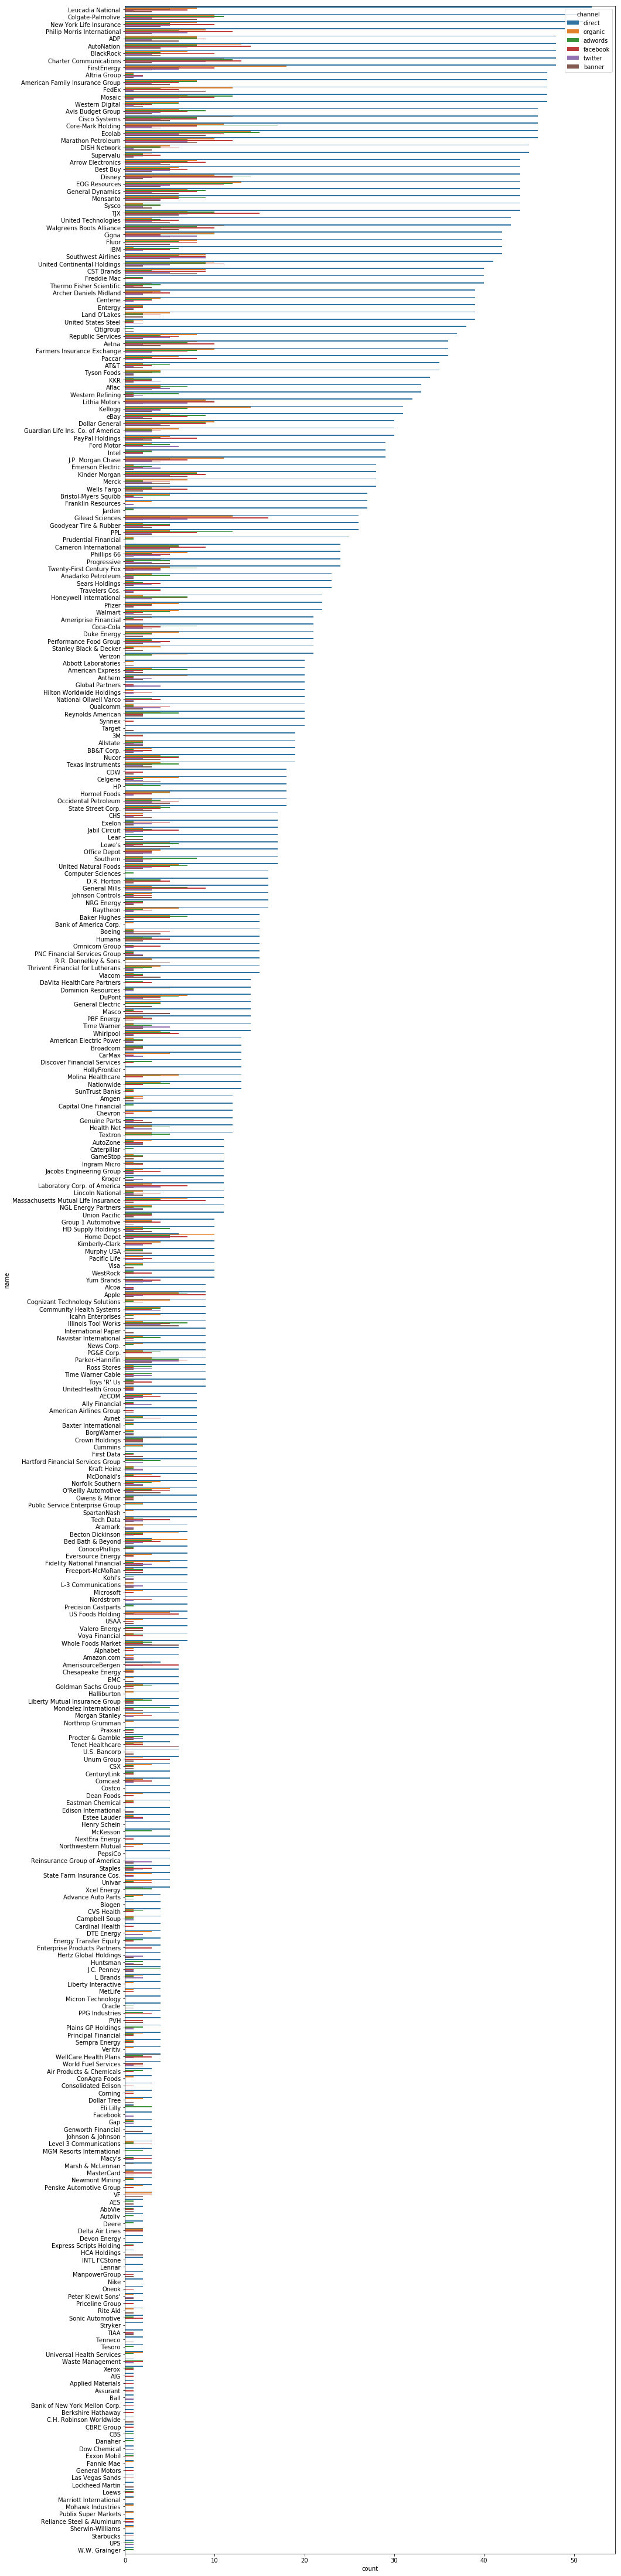

In [172]:
plt.figure(figsize=(15, 80))
sns.barplot(x='count', y='name', hue='channel', data=df);

Although it is not easy to read, even at this size, the visualization makes it abundantly clear that the `direct` channel (blue line) is by far the most common channel for most companies. 

### Date
We need additional functions to group by date because otherwise, **GROUP BY** will group by exactly the same date, down to the second. There are two key date functions to use:
- **DATE_TRUNC**: Can group according to `second`, `day`, `month`, `year` but will group months in different years separately.
- **DATE_PART**: Can group accoding to these but will group info in different years together. `dow` is used to group information by day of the week. (Note: Day of the week will be listed as integers with Sunday = 0)

The **DATE** statements are included in the **SELECT** statement. For example:
```sql
SELECT DATE_PART('dow', occurred_at) AS day_of_week,
       SUM(total) AS total_qty
FROM orders
GROUP BY 1
ORDER BY 2 DESC;
```

1. Find the sales in terms of total dollars for all orders in each year, ordered from greatest to least. Do you notice any trends in the yearly sales totals?
2. Which month did Parch & Posey have the greatest sales in terms of total dollars? Are all months evenly represented by the dataset?
3. Which year did Parch & Posey have the greatest sales in terms of total number of orders? Are all years evenly represented by the dataset?
4. Which month did Parch & Posey have the greatest sales in terms of total number of orders? Are all months evenly represented by the dataset?
5. In which month of which year did Walmart spend the most on gloss paper in terms of dollars?

When working with sqlite, `DATE_PART` needs to be substituted for `STRFTIME`. Details on using dates with sqlite can be found [here](https://www.sqlite.org/lang_datefunc.html).

As a result I have included the queries as both the postgres query and then executed the sqlite query.

```sql
/* 1. Find the sales in terms of total dollars for all orders in each 
      year, ordered from greatest to least.*/
SELECT DATE_PART('year', ocurred_at) year_of_sales, 
       SUM(total_amt_usd) total_sales
FROM orders
GROUP BY 1
ORDER BY 2 DESC;
```

In [36]:
sql_query('SELECT STRFTIME("%Y", occurred_at) year_of_sales, \
                  SUM(total_amt_usd) total_sales \
           FROM orders \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,year_of_sales,total_sales
0,2016,12864917.92
1,2015,5752004.94
2,2014,4069106.54
3,2013,377331.00
4,2017,78151.43


The month with the greatest sales is 2016, by a substantial amount.

The results of the above show that we only have partial data for the years 2013 and 2017. If we are going to fairly compare each month, we should only look at the years from 2014 to 2016.

```sql
/* 2. Which month did Parch & Posey have the greatest sales in terms 
      of total dollars? */
SELECT DATE_PART('month', occurred_at) month, 
       SUM(total_amt_usd) total_sales
FROM orders 
WHERE occurred_at BETWEEN '2014-01-01' AND '2017-01-01'
GROUP BY 1
ORDER BY 2 DESC;
```

In [38]:
sql_query('SELECT STRFTIME("%m", occurred_at) sales_month, \
                  SUM(total_amt_usd) total_sales \
           FROM orders \
           WHERE occurred_at BETWEEN "2014-01-01" AND "2017-01-01" \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,sales_month,total_sales
0,12,2752080.98
1,10,2427505.97
2,11,2390033.75
3,09,2017216.88
4,07,1978731.15
5,08,1918107.22
6,06,1871118.52
7,03,1659987.88
8,04,1562037.74
9,05,1537082.23


There is the greatest amount of sales in the month of December. 

Note that the date filtering is based on the original format and not the truncated format.

```sql
/* 3. Which year did Parch & Posey have the greatest sales in terms of total number of orders? */
SELECT DATE_PART('year', occurred_at) year_of_sales, 
       COUNT(*) total_orders
FROM orders
GROUP BY 1
ORDER BY 2 DESC;
```

In [39]:
sql_query('SELECT STRFTIME("%Y", occurred_at) sales_year, \
                  COUNT(*) total_orders \
           FROM orders \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,sales_year,total_orders
0,2016,3757
1,2015,1725
2,2014,1306
3,2013,99
4,2017,25


The most orders were made in 2016.

```sql
/* 4. Which month did Parch & Posey have the greatest sales in terms 
      of total number of orders? */
SELECT DATE_PART('month', occurred_at)
       COUNT(*)
FROM orders
WHERE occurred_at BETWEEN '2014-01-01' AND '2017-01-01'
GROUP BY 1
ORDER BY 2 DESC;
```

In [42]:
sql_query('SELECT STRFTIME("%m", occurred_at) sales_month, \
                  COUNT(*) total_orders \
           FROM orders \
           WHERE occurred_at BETWEEN "2014-01-01" AND "2017-01-01" \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,sales_month,total_orders
0,12,783
1,11,713
2,10,675
3,08,603
4,09,602
5,07,571
6,06,527
7,05,518
8,03,482
9,04,472


December also had the most sales by number of orders.

```sql
/* 5. In which month of which year did Walmart spend the most on gloss
      paper in terms of dollars? */
SELECT DATE_PART('month', o.occurred_at) month_of_sales, 
       SUM(o.gloss_amt_usd) gloss_sales 
FROM orders o
JOIN accounts a
ON a.id = o.account_id
WHERE a.name = 'Walmart'
GROUP BY 1
ORDER BY 2 DESC;
```

In [45]:
sql_query('SELECT STRFTIME("%Y", o.occurred_at) sales_year, \
                  SUM(o.gloss_amt_usd) gloss_sales \
           FROM orders o \
           JOIN accounts a \
           ON a.id = o.account_id \
           WHERE a.name = "Walmart" \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,sales_year,gloss_sales
0,2016,48774.88
1,2015,9879.31


The most gloss sales in terms of dollars for Walmart occurred in 2016. 

### Case
The **CASE** statement is SQL's way of handling "IF" "THEN" logic and creates a derived column. 

It always goes in the **SELECT** clause and must include the following components: **WHEN**, **THEN**, and **END**. **ELSE** is an optional inclusion.

For example:
```sql
SELECT id, 
       account_id,
       occurred_at, 
       channel, 
       CASE WHEN channel = 'facebook' THEN 'yes' ELSE 'no' END AS is_facebook
FROM web_events
ORDER BY occurred_at
```

You can also use multiple **WHEN** statements to create multiple conditions. (This essentially functions as `elif`). 

For example:
```sql
SELECT account_id,
       occurred_at,
       total, 
       CASE WHEN total > 500 THEN 'Over 500'
            WHEN total > 300 AND total <= 500 THEN '301 - 500'
            WHEN total > 100 AND total <= 300 THEN '101 - 300'
            ELSE '100 or under' END AS total_group
FROM orders
```

The above can be written as `WHEN total > 300 THEN '301 - 500'` but it is clearer to make statements that do not overlap. All logical operators, including **WHERE** can be included in **WHEN** statments.

The easiest way to count by levels of a category is to create a column that counts the way you would like, and then count by that group.

For example:
```sql
SELECT CASE WHEN total > 500 THEN 'Over 500'
            ELSE '500 or Under' END AS total_group,
       COUNT(*) AS order_count
FROM orders
GROUP BY 1;
```

1. Write a query to display for each order, the account ID, total amount of the order, and the level of the order - ‘Large’ or ’Small’ - depending on if the order is \$3000 or more, or smaller than \$3000.
2. Write a query to display the number of orders in each of three categories, based on the 'total' amount of each order. The three categories are: 'At Least 2000', 'Between 1000 and 2000' and 'Less than 1000'.
3. We would like to understand 3 different levels of customers based on the amount associated with their purchases. The top level includes anyone with a Lifetime Value (total sales of all orders) `greater than 200,000` usd. The second level is `between 200,000 and 100,000` usd. The lowest level is anyone `under 100,000` usd. Provide a table that includes the **level** associated with each **account**. You should provide the **account name**, the **total sales of all orders** for the customer, and the **level**. Order with the top spending customers listed first.
4. We would now like to perform a similar calculation to the first, but we want to obtain the total amount spent by customers only in `2016` and `2017`. Keep the same levels as in the previous question. Order with the top spending customers listed first.
5. We would like to identify top performing **sales reps**, which are sales reps associated with `more than 200` orders. Create a table with the **sales rep name**, the **total number of orders**, and a column with `top` or `not` depending on if they have more than 200 orders. Place the top sales people first in your final table.
6. The previous didn't account for the middle, nor the dollar amount associated with the sales. Management decides they want to see these characteristics represented as well. We would like to identify `top` performing **sales reps**, which are sales reps associated with `more than 200` orders or `more than 750000` in total sales. The `middle` group has any rep with `more than 150` orders or `500000` in sales. Create a table with the **sales rep name**, the **total number of orders**, **total sales** across all orders, and a column with `top`, `middle`, or `low` depending on this criteria. Place the top sales people _based on dollar amount of sales_ first in your final table. You might see a few upset sales people by this criteria!

In [205]:
# 1 For each order, the account ID, total amount of the order, and the
#   level of the order - ‘Large’ or ’Small’ - if the order >= $3000
sql_query('SELECT account_id, \
                  total_amt_usd, \
                  CASE WHEN total_amt_usd >= 3000 THEN "Large" \
                       ELSE "Small" END AS order_size \
           FROM orders;')

,account_id,total_amt_usd,order_size
0,1001,973.43,Small
1,1001,1718.03,Small
2,1001,776.18,Small
3,1001,958.24,Small
4,1001,983.49,Small
5,1001,1067.25,Small
6,1001,1498.20,Small
7,1001,2052.20,Small
8,1001,752.57,Small
9,1001,878.56,Small


In [207]:
# 2 Number of orders in each of three categories, based on the 'total' amount 
#   of each order. The three categories are: 'At Least 2000', 'Between 1000 
#   and 2000' and 'Less than 1000'.
sql_query('SELECT CASE WHEN total >= 2000 THEN "At Least 2000" \
                       WHEN total BETWEEN 1000 AND 1999 THEN "Between 1000 and 2000" \
                       ELSE "Less than 1000" END AS order_size, \
                  COUNT(*) count \
           FROM orders \
           GROUP BY 1;')

,order_size,count
0,At Least 2000,70
1,Between 1000 and 2000,511
2,Less than 1000,6331


In [219]:
# 3 Total sales of all orders greater than 200,000 usd. The second level is 
#   between 200,000 and 100,000 usd. The lowest level is under 100,000 usd.
sql_query('SELECT a.name account, \
                  SUM(total_amt_usd) lifetime_value, \
                  CASE WHEN SUM(total_amt_usd) > 200000 THEN "top" \
                       WHEN SUM(total_amt_usd) BETWEEN 100000 AND 199999 THEN "middle" \
                       ELSE "bottom" END AS account_type \
           FROM orders o \
           JOIN accounts a \
           ON a.id = o.account_id \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,account,lifetime_value,account_type
0,EOG Resources,382873.30,top
1,Mosaic,345618.59,top
2,IBM,326819.48,top
3,General Dynamics,300694.79,top
4,Republic Services,293861.14,top
5,Leucadia National,291047.25,top
6,Arrow Electronics,281018.36,top
7,Sysco,278575.64,top
8,Supervalu,275288.30,top
9,Archer Daniels Midland,272672.84,top


In [212]:
# 4 As above, but only for 2016 and 2017.
sql_query('SELECT a.name account, \
                  SUM(total_amt_usd) lifetime_value, \
                  CASE WHEN SUM(total_amt_usd) > 200000 THEN "top" \
                       WHEN SUM(total_amt_usd) BETWEEN 100000 AND 199999 THEN "middle" \
                       ELSE "bottom" END AS account_type \
           FROM orders o \
           JOIN accounts a \
           ON a.id = o.account_id \
           WHERE occurred_at >= "2016-01-01" \
           GROUP BY 1 -- Dont need 3 because also aggregate \
           ORDER BY 2 DESC;')

,account,lifetime_value,account_type
0,Pacific Life,255319.18,top
1,Mosaic,172180.04,middle
2,CHS,163471.78,middle
3,Core-Mark Holding,148105.93,middle
4,Disney,129157.38,middle
5,National Oilwell Varco,121873.16,middle
6,Sears Holdings,114003.21,middle
7,State Farm Insurance Cos.,111810.55,middle
8,Fidelity National Financial,110027.29,middle
9,BB&T Corp.,107300.05,middle


In [216]:
# 5 Top performing sales reps, associated with more than 200 orders. Show 
#   sales rep name, total number of orders, column with top or not.
sql_query('SELECT s.name rep, \
                  COUNT(*) total_orders, \
                  CASE WHEN COUNT(*) > 200 THEN "top" \
                       ELSE "not" END AS "top or not" \
           FROM sales_reps s \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,rep,total_orders,top or not
0,Earlie Schleusner,335,top
1,Vernita Plump,299,top
2,Tia Amato,267,top
3,Georgianna Chisholm,256,top
4,Moon Torian,250,top
5,Nelle Meaux,241,top
6,Maren Musto,224,top
7,Dorotha Seawell,208,top
8,Charles Bidwell,205,top
9,Maryanna Fiorentino,204,top


In [220]:
# 6 Top sales reps: > 200 orders or > 750000 in total sales
#   Middle: > 150 orders or 500000 in total sales. Or Low, ordered by high sales
sql_query('SELECT r.name rep, \
                  COUNT(*) orders_sold, \
                  SUM(o.total_amt_usd) total_sales, \
                  CASE WHEN COUNT(*) > 200 OR SUM(o.total_amt_usd) > 750000 THEN "top" \
                       WHEN COUNT(*) > 150 OR SUM(o.total_amt_usd) > 500000 THEN "middle" \
                       ELSE "low" END AS ranking \
           FROM sales_reps r \
           JOIN accounts a \
           ON r.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY rep \
           ORDER BY 3 DESC;')

,rep,orders_sold,total_sales,ranking
0,Earlie Schleusner,335,1098137.72,top
1,Tia Amato,267,1010690.60,top
2,Vernita Plump,299,934212.93,top
3,Georgianna Chisholm,256,886244.12,top
4,Arica Stoltzfus,186,810353.34,top
5,Dorotha Seawell,208,766935.04,top
6,Nelle Meaux,241,749076.16,top
7,Sibyl Lauria,193,722084.27,middle
8,Maren Musto,224,702697.29,top
9,Brandie Riva,167,675917.64,middle


<a id='subq'></a>
## Lesson 4: Suqueries & Temporary Tables
### Subqueries
Subqueries (or nested queries) can allow you to perform queries in multiple steps.

For example, to find the average number of web events per day per channel:
```sql
SELECT channel,
	   AVG(num_events) avg_events
FROM(SELECT DATE_TRUNC('day', occurred_at) AS day, 
            channel, 
            COUNT(*) num_events
  	 FROM web_events
	 GROUP BY 1, 2
	 ORDER BY num_events DESC) as Table1
GROUP BY 1;
```

It can also be helpful to use the value of a subquery to act as a filter or conditional statement for a larger query.

For example, to get all orders from the first month:
```sql
SELECT *
FROM orders
WHERE DATE_TRUNC('month', occurred_at) = 
    (SELECT DATE_TRUNC('month', MIN(occurred_at)) AS min_month
     FROM orders)   -- Gets month of first order
ORDER BY occurred_at;
```

Most conditional logic will work when the inner query only contains one result but **IN** is the only logic statement that will work with multiple results.

In the dialect from our lessons, if we return a full table we need to use an alias. If we return a column, we need to use an **IN** statement, but if we only return a single value, we don't need to use an alias.

**First Quiz**

Find the average amount of paper ordered by each type in the first month that orders were taken. (Uses `DATE_TRUNC` so just including as markdown)

```sql
SELECT AVG(standard_qty) avg_std,
	   AVG(gloss_qty) avg_gls,
       AVG(poster_qty) avg_poster
FROM orders
WHERE DATE_TRUNC('month', occurred_at) =
	(SELECT DATE_TRUNC('month', MIN(occurred_at))
	 FROM orders);
```

Output:
![title](results1.PNG)

1. Provide the name of the sales_rep in each region with the largest amount of total_amt_usd sales.
2. For the region with the largest (sum) of sales total_amt_usd, how many total (count) orders were placed? 
3. For the name of the account that purchased the most (in total over their lifetime as a customer) standard_qty paper, how many accounts still had more in total purchases? 
4. For the customer that spent the most (in total over their lifetime as a customer) total_amt_usd, how many web_events did they have for each channel?
5. What is the lifetime average amount spent in terms of total_amt_usd for the top 10 total spending accounts?
6. What is the lifetime average amount spent in terms of total_amt_usd for only the companies that spent more than the average of all orders.

In [224]:
# 1 Name of the sales_rep in each region with the largest total_amt_usd sales
# Build subquery - find total sales per rep with region
sql_query('SELECT s.name rep, \
                  r.name AS region, \
                  SUM(o.total_amt_usd) total_sales \
           FROM region r \
           JOIN sales_reps s \
           ON r.id = s.region_id \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY 1, 2;')

,rep,region,total_sales
0,Akilah Drinkard,Northeast,136613.99
1,Arica Stoltzfus,West,810353.34
2,Ayesha Monica,Northeast,217146.59
3,Babette Soukup,Southeast,215905.27
4,Brandie Riva,West,675917.64
5,Calvin Ollison,Southeast,594516.08
6,Cara Clarke,Northeast,166138.65
7,Carletta Kosinski,Midwest,213032.45
8,Charles Bidwell,Midwest,675637.19
9,Chau Rowles,Midwest,184282.60


In [226]:
# Create full query - group by region having max sales per rep
sql_query('SELECT region, rep AS highest_sales_rep \
           FROM(SELECT s.name rep, \
                       r.name AS region, \
                       SUM(o.total_amt_usd) total_sales \
                FROM region r \
                JOIN sales_reps s \
                ON r.id = s.region_id \
                JOIN accounts a \
                ON s.id = a.sales_rep_id \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY 1, 2) AS sub \
            GROUP BY region \
            HAVING total_sales = MAX(total_sales);')

,region,highest_sales_rep
0,Midwest,Charles Bidwell
1,Northeast,Tia Amato
2,Southeast,Earlie Schleusner
3,West,Georgianna Chisholm


In [227]:
# 2 For the region with the largest total_amt_usd, how many orders were placed?
# Create subquery - find total sales per region
sql_query('SELECT r.name AS region, \
                  SUM(o.total_amt_usd) total_sales \
           FROM region r \
           JOIN sales_reps s \
           ON r.id = s.region_id \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY r.name;')

,region,total_sales
0,Midwest,3013486.51
1,Northeast,7744405.36
2,Southeast,6458497.00
3,West,5925122.96


In [238]:
# Create next subquery - select max value
sql_query('SELECT MAX(total_sales) \
           FROM(SELECT r.name AS region, \
                       SUM(o.total_amt_usd) total_sales \
                FROM region r \
                JOIN sales_reps s \
                ON r.id = s.region_id \
                JOIN accounts a \
                ON s.id = a.sales_rep_id \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY r.name) t1;')

,MAX(total_sales)
0,7744405.36


In [241]:
# Create final query - group total orders by account and filter having max total sales
sql_query('SELECT r.name, \
                  COUNT(o.total) total_orders \
           FROM region r \
           JOIN sales_reps s \
           ON r.id = s.region_id \
           JOIN accounts a \
           ON s.id = a.sales_rep_id \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY r.name \
           HAVING SUM(o.total_amt_usd) = \
                  (SELECT MAX(total_sales) \
                   FROM(SELECT r.name AS region, \
                               SUM(o.total_amt_usd) total_sales \
                        FROM region r \
                        JOIN sales_reps s \
                        ON r.id = s.region_id \
                        JOIN accounts a \
                        ON s.id = a.sales_rep_id \
                        JOIN orders o \
                        ON a.id = o.account_id \
                        GROUP BY r.name) t1);')

,name,total_orders
0,Northeast,2357


In [243]:
# 3 For account that purchased the most standard_qty , how many accounts 
#   had more in total purchases?
# Create subquery - sum standard_qty per account
sql_query('SELECT SUM(o.standard_qty) total_std_orders \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY a.name;')

,total_std_orders
0,8775
1,21278
2,3274
3,764
4,601
5,4603
6,715
7,6033
8,1096
9,11689


In [245]:
# Create subquery - find max total_std
# Could have removed this step by ordering above and selecting first
sql_query('SELECT MAX(total_std_orders) \
           FROM(SELECT SUM(o.standard_qty) total_std_orders \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY a.name);')

,MAX(total_std_orders)
0,41617


In [246]:
# Create next query - filter for accounts with total orders above max std
sql_query('SELECT a.name \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY a.name \
           HAVING SUM(o.total) > \
                  (SELECT MAX(total_std_orders) \
                   FROM(SELECT SUM(o.standard_qty) total_std_orders \
                        FROM accounts a \
                        JOIN orders o \
                        ON a.id = o.account_id \
                        GROUP BY a.name));')

,name
0,Core-Mark Holding
1,EOG Resources
2,General Dynamics
3,IBM
4,Leucadia National
5,Mosaic


In [247]:
# Create final query - count them
sql_query('SELECT COUNT(*) \
           FROM(SELECT a.name \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY a.name \
                HAVING SUM(o.total) > \
                      (SELECT MAX(total_std_orders) \
                       FROM(SELECT SUM(o.standard_qty) total_std_orders \
                            FROM accounts a \
                            JOIN orders o \
                            ON a.id = o.account_id \
                            GROUP BY a.name)));')

,COUNT(*)
0,6


In [248]:
# 4 For the customer that spent the most, how many web_events did they have 
#   for each channel?
# Create subquery - find the customer that spent the most
sql_query('SELECT a.name, \
                  SUM(o.total_amt_usd) \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY 1 \
           ORDER BY 2 DESC \
           LIMIT 1;')

,name,SUM(o.total_amt_usd)
0,EOG Resources,382873.3


In [251]:
# Create subquery - join on account name from subquery and group channel count
sql_query('SELECT w.channel, \
                  COUNT(*) num_events \
           FROM web_events w \
           JOIN accounts a \
           ON w.account_id = a.id \
           JOIN (SELECT a.name, \
                        SUM(o.total_amt_usd) \
                 FROM accounts a \
                 JOIN orders o \
                 ON a.id = o.account_id \
                 GROUP BY 1 \
                 ORDER BY 2 DESC \
                 LIMIT 1) AS t1\
           ON a.name = t1.name \
           GROUP BY 1;')

,channel,num_events
0,adwords,12
1,banner,4
2,direct,44
3,facebook,11
4,organic,13
5,twitter,5


In [252]:
# 5 Lifetime average amount spent for the top 10 total spending accounts?
# Create subquery - top 10 spending accounts
sql_query('SELECT a.name, \
                  SUM(o.total_amt_usd) \
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY 1 \
           ORDER BY 2 DESC \
           LIMIT 10;')

,name,SUM(o.total_amt_usd)
0,EOG Resources,382873.30
1,Mosaic,345618.59
2,IBM,326819.48
3,General Dynamics,300694.79
4,Republic Services,293861.14
5,Leucadia National,291047.25
6,Arrow Electronics,281018.36
7,Sysco,278575.64
8,Supervalu,275288.30
9,Archer Daniels Midland,272672.84


In [255]:
# Create subquery - I could join on this as before, or use IN
sql_query('SELECT a.name, \
                  AVG(o.total_amt_usd) avg_order_usd\
           FROM accounts a \
           JOIN orders o \
           ON a.id = o.account_id \
           GROUP BY 1 \
           HAVING a.name IN (SELECT name \
                             FROM(SELECT a.name, \
                                         SUM(o.total_amt_usd) \
                                  FROM accounts a \
                                  JOIN orders o \
                                  ON a.id = o.account_id \
                                  GROUP BY 1 \
                                  ORDER BY 2 DESC \
                                  LIMIT 10) AS t1) \
           ORDER BY 2;')

,name,avg_order_usd
0,Supervalu,4048.357353
1,Sysco,4096.700588
2,Leucadia National,4099.257042
3,Archer Daniels Midland,4131.406667
4,Arrow Electronics,4194.303881
5,General Dynamics,4555.981667
6,Mosaic,5236.645303
7,IBM,5446.991333
8,Republic Services,5877.222800
9,EOG Resources,6175.375806


This is apparently not what we wanted. Instead, all we wanted was the lifetime average for the top 10.

In [256]:
sql_query('SELECT AVG(total_spent) \
           FROM(SELECT a.name, \
                       SUM(o.total_amt_usd) total_spent \
                FROM accounts a \
                JOIN orders o \
                ON a.id = o.account_id \
                GROUP BY 1 \
                ORDER BY 2 DESC \
                LIMIT 10) AS t1;')

,AVG(total_spent)
0,304846.969


In [260]:
# 6 Lifetime average amount spent for companies that spent more than the 
#   average of all orders.
# Create subquery - find the average of all orders
sql_query('SELECT AVG(total_amt_usd) \
           FROM orders;')

,AVG(total_amt_usd)
0,3348.019651


In [267]:
# Create subquery - find companies where their average is great than above
sql_query('SELECT account_id \
           FROM orders \
           GROUP BY 1 \
           HAVING AVG(total_amt_usd) > \
                  (SELECT AVG(total_amt_usd) \
                   FROM orders);')

,account_id
0,1001
1,1031
2,1061
3,1071
4,1081
5,1111
6,1121
7,1131
8,1141
9,1171


In [268]:
# Create final query - find average for the orders for these companies
sql_query('SELECT AVG(total_amt_usd) \
           FROM orders \
           WHERE account_id IN (SELECT account_id \
                                FROM orders \
                                GROUP BY 1 \
                                HAVING AVG(total_amt_usd) > \
                                      (SELECT AVG(total_amt_usd) \
                                       FROM orders));')

,AVG(total_amt_usd)
0,4434.212798


This is slightly different than what was given as the solution, but I think this is more correct. 

The solution instead did:

In [269]:
sql_query('SELECT AVG(avg_orders) \
           FROM(SELECT account_id, \
                       AVG(total_amt_usd) avg_orders \
                FROM orders \
                GROUP BY 1 \
                HAVING AVG(total_amt_usd) > \
                      (SELECT AVG(total_amt_usd) \
                       FROM orders));')

,AVG(avg_orders)
0,4721.139744


The reason that this is less correct is that gives the average of the average, but this is not actually the average of all orders.

### With & Temporary Tables
If you have a really long subquery that takes a long time to run, you can improve the speed by writing it as a table back into the database and using **WITH**. These types of statements are also called **Common Table Expressions** or **CTEs**.

The idea here is that you have a fast outer query but a slow inner query. So if you don't have to constantly generate the inner query, then running changes to the outer query will be much faster.

This looks something like this:
```sql
WITH events AS (SELECT DATE_TRUNC('day', occurred_at) AS day,
                       channel,
                       COUNT(*) AS event_count
                FROM web_events
                GROUP BY 1, 2)

SELECT channel,
       AVG(event_count) AS avg_event_count
FROM events
GROUP BY 1
ORDER BY 2 DESC
```

This allows us to let the initial query act as a table to query from.

It's also possible to create multiple tables using the **WITH** statement:
```sql
WITH table1 AS (
        SELECT *
        FROM web_events),
        
     table2 AS (
         SELECT *
         FROM accounts)

SELECT *
FROM table1
JOIN table2
ON table1.account_id = table2.id;
```

This is a bit of an unnecessary query, but it does show the functionality.

For these questions we are going to use the same questions as above, but using **WITH** statements.

1. Provide the name of the sales_rep in each region with the largest amount of total_amt_usd sales.
2. For the region with the largest (sum) of sales total_amt_usd, how many total (count) orders were placed? 
3. For the name of the account that purchased the most (in total over their lifetime as a customer) standard_qty paper, how many accounts still had more in total purchases? 
4. For the customer that spent the most (in total over their lifetime as a customer) total_amt_usd, how many web_events did they have for each channel?
5. What is the lifetime average amount spent in terms of total_amt_usd for the top 10 total spending accounts?
6. What is the lifetime average amount spent in terms of total_amt_usd for only the companies that spent more than the average of all orders.

In [279]:
# 1 Sales rep in each region with largest amount of sales (in $)
sql_query('WITH t1 AS ( \
                        SELECT s.name rep, \
                               r.name AS region, \
                               SUM(o.total_amt_usd) total_sales \
                        FROM region r \
                        JOIN sales_reps s \
                        ON r.id = s.region_id \
                        JOIN accounts a \
                        ON s.id = a.sales_rep_id \
                        JOIN orders o \
                        ON a.id = o.account_id \
                        GROUP BY 1, 2), \
                        \
                t2 AS ( \
                        SELECT region, MAX(total_sales) max_sales\
                        FROM t1 \
                        GROUP BY 1) \
                        \
          SELECT t1.rep, t1.region \
          FROM t1 \
          JOIN t2 \
          ON t1.region = t2.region AND t1.total_sales = t2.max_sales;')

,rep,region
0,Charles Bidwell,Midwest
1,Earlie Schleusner,Southeast
2,Georgianna Chisholm,West
3,Tia Amato,Northeast


In [283]:
# 2 For highest sales ($) region, how many orders placed
sql_query('WITH t1 AS ( \
                    SELECT r.name AS region, \
                           SUM(o.total_amt_usd) \
                    FROM region r \
                    JOIN sales_reps s \
                    ON r.id = s.region_id \
                    JOIN accounts a \
                    ON s.id = a.sales_rep_id \
                    JOIN orders o \
                    ON a.id = o.account_id \
                    GROUP BY 1 \
                    ORDER BY 2 DESC \
                    LIMIT 1) -- Finds region with max $ \
                    \
            SELECT r.name, COUNT(*) num_orders \
            FROM orders o \
            JOIN accounts a \
            ON o.account_id = a.id \
            JOIN sales_reps s \
            ON a.sales_rep_id = s.id \
            JOIN region r \
            ON s.region_id = r.id \
            JOIN t1 \
            ON r.name = t1.region;')

,name,num_orders
0,Northeast,2357


In [289]:
# 3 For highest account with highest standard_qty, accounts with had more total
sql_query('WITH t1 AS ( \
                    SELECT a.id, \
                           SUM(o.standard_qty) total_std\
                    FROM accounts a \
                    JOIN orders o \
                    ON a.id = o.account_id \
                    GROUP BY 1 \
                    ORDER BY 2 DESC \
                    LIMIT 1), \ 
                    \
                t2 AS ( \
                    SELECT account_id \
                    FROM orders \
                    GROUP BY 1 \
                    HAVING SUM(total) > \
                           (SELECT total_std \
                            FROM t1)) \
                    \
            SELECT COUNT(*) \
            FROM t2;')

,COUNT(*)
0,6


In [292]:
# 4 For account who spent the most, how many web events for each channel
sql_query('WITH t1 AS ( \
                    SELECT account_id, \
                           SUM(total_amt_usd) \
                    FROM orders \
                    GROUP BY 1 \
                    ORDER BY 2 DESC \
                    LIMIT 1) \
                    \
            SELECT channel, \
                   COUNT(*) num_events \
                   FROM web_events w \
                   WHERE account_id = (SELECT account_id \
                                       FROM t1) \
                   GROUP BY 1;')

,channel,num_events
0,adwords,12
1,banner,4
2,direct,44
3,facebook,11
4,organic,13
5,twitter,5


In [293]:
# 5 Lifetime average spent for top 10 spending accounts
sql_query('WITH t1 AS ( \
                    SELECT account_id, \
                           SUM(total_amt_usd) total_spent\
                    FROM orders \
                    GROUP BY 1 \
                    ORDER BY 2 DESC \
                    LIMIT 10) \
                    \
            SELECT AVG(total_spent) \
            FROM t1;')

,AVG(total_spent)
0,304846.969


In [297]:
# 6 Lifetime average spent for companies that spent > average of all accounts
sql_query('WITH t1 AS ( \
                    SELECT account_id, \
                           SUM(total_amt_usd) total_spent\
                    FROM orders \
                    GROUP BY 1) \
                    \
           SELECT AVG(total_spent) \
           FROM t1 \
           WHERE total_spent > (SELECT AVG(total_spent) \
                                FROM t1);')

,AVG(total_spent)
0,145956.765508


While this is different from what I calculated previously, I think, based on the previous answer this is actually what we are looking for. 

I do think that using CTEs is clearer than using subqueries in a general sense.

<a id='clean'></a>
## Lesson 5: Data Cleaning
### Left & Right
These two statements can be used to start at one end of a string and include the first X number of elements starting from that direction. For example, if we were looking to pull phone numbers from data, we might try:

```sql
SELECT first_name,
       last_name,
       phone_number,
       LEFT(phone_number, 3) AS area_code,
       RIGHT(phone_number, 8) AS phone_number_only
FROM customer_data
```

### Length
The **LENGTH** function pulls the length of a string.

It is possible to use **LENGTH** in an embedded way:
```sql
SELECT first_name,
       last_name,
       phone_number,
       LEFT(phone_number, 3) AS area_code,
       RIGHT(phone_number, LENGTH(phone_number) - 4) AS phone_number_only
FROM customer_data
```

1. In the accounts table, there is a column holding the website for each company. The last three digits specify what type of web address they are using. A list of extensions (and pricing) is provided [here](https://iwantmyname.com/domains). Pull these extensions and provide how many of each website type exist in the accounts table.
2. There is much debate about how much the name (or even the first letter of a company name) matters. Use the accounts table to pull the first letter of each company name to see the distribution of company names that begin with each letter (or number). 
3. Use the accounts table and a CASE statement to create two groups: one group of company names that start with a number and a second group of those company names that start with a letter. What proportion of company names start with a letter?
4. Consider vowels as a, e, i, o, and u. What proportion of company names start with a vowel, and what percent start with anything else?

Instead of using **RIGTH** in sqlite, I need to use **SUBSTR** and specify the direction as negative. For example, to get the last three digits, the argument would be `-3`.

Both the syntax within the classroom (postgres) and sqlite are included below.

```sql
/* 1. Count of website extentions */
WITH t1 AS (
  	SELECT RIGHT(website, 3) web_ext
  	FROM accounts )
    
SELECT web_ext, COUNT(*) num
FROM t1
GROUP BY 1
```

In [48]:
sql_query('SELECT SUBSTR(website, -3) web_ext, \
                  COUNT(*) num \
           FROM accounts \
           GROUP BY 1;')

,web_ext,num
0,com,349
1,net,1
2,org,1


Note: I corrected the query and made it much simpler than the original version. 

The `com` extension is by far the most common web extension.

```sql
/* 2. Distribution of company starting letter/number */
WITH t1 AS (
  		SELECT LEFT(UPPER(name), 1) name_start
  		FROM accounts
  			)

SELECT name_start, 
	   COUNT(*) AS start_count
FROM t1
GROUP BY 1
ORDER BY 2 DESC
```

In [55]:
sql_query('SELECT SUBSTR(UPPER(name), 1, 1) name_start, \
                  COUNT(*) num \
           FROM accounts \
           GROUP BY 1 \
           ORDER BY 2 DESC;')

,name_start,num
0,A,37
1,C,37
2,P,27
3,M,22
4,D,17
5,S,17
6,T,17
7,B,16
8,E,16
9,L,16


Interestingly, there are 26 rows that also include an `3`. This means that one letter of the alphabet is missing. The missing letter is `Z`. 

The most common starting letters are A, C, P and M. The least common starting letters are Y, Q and X.

```sql
/* 3. Proportion of company names that start with a letter */
WITH t1 AS (
  	SELECT LEFT(UPPER(name), 1) name_start
  	FROM accounts),
    
     t2 AS (
	SELECT CASE WHEN name_start IN ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9') THEN 'num'
       			ELSE 'alpha' END AS start_type
    FROM t1)
    
SELECT start_type, 
       COUNT(*) as type_count
FROM t2
GROUP BY 1;
```

In [62]:
sql_query('WITH t1 AS ( \
                 SELECT SUBSTR(UPPER(name), 1, 1) name_start \
                 FROM accounts), \
                 \
                t2 AS ( \
                 SELECT CASE WHEN name_start IN ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9") THEN "num" \
                                  ELSE "alpha" END start_type \
                 FROM t1) \
                 \
           SELECT start_type, \
                  COUNT(*) as type_count \
           FROM t2 \
           GROUP BY 1;')

,start_type,type_count
0,alpha,350
1,num,1


In [305]:
print('Proportion starting with number:', 1/351*100)
print('Proportion starting with letter:', 350/351*100)

Proportion starting with number: 0.2849002849002849
Proportion starting with letter: 99.71509971509973


```sql
/* 5. Proportion of companies starting with a vowel */
WITH t1 AS (
  	SELECT LEFT(UPPER(name), 1) name_start
  	FROM accounts),
    
     t2 AS (
	SELECT CASE WHEN name_start IN ('A', 'E', 'I', 'O', 'U') THEN 'vowel'
       		 ELSE 'non-vowel' END AS start_type
    FROM t1)
    
SELECT start_type, 
       COUNT(*) as type_count
FROM t2
GROUP BY 1;
```

In [63]:
sql_query('WITH t1 AS ( \
                 SELECT SUBSTR(UPPER(name), 1, 1) name_start \
                 FROM accounts), \
                 \
                t2 AS ( \
                 SELECT CASE WHEN name_start IN ("A", "E", "I", "O", "U") THEN "vowel" \
                                  ELSE "non-vowel" END start_type \
                 FROM t1) \
                 \
           SELECT start_type, \
                  COUNT(*) as type_count \
           FROM t2 \
           GROUP BY 1;')

,start_type,type_count
0,non-vowel,271
1,vowel,80


In [316]:
print('Proportion of companies starting with a vowel: {:.2f}%'.format(80/(80 + 271)*100))
print('Proportion of companies starting with a non-vowel: {:.2f}%'.format(271/(80 + 271)*100))

Proportion of companies starting with a vowel: 22.79%
Proportion of companies starting with a non-vowel: 77.21%


### POSITION, STRPOS & SUBSTR
**POSITION** allows us to find the position of a string within a row. For example, to find the position of the comma in a `city, state` field:

```sql
SELECT first_name, 
       last_name, 
       city_state, 
       POSITION(',' IN city_state) AS comma_position
FROM customers
```

This is the equivalent of the following code using **STRPOS**:

```sql
SELECT first_name, 
       last_name, 
       city_state, 
       STRPOS(city_state, ',') AS comma_position
FROM customers
```

As we saw in the above examples, we can also use **LOWER** and **UPPER** to make all the characters in a string lower- or upper-case respectively.

We can combine this to just extract the city from the info as follows:
```sql
SELECT first_name, 
       last_name, 
       city_state, 
       LEFT(city_state, STRPOS(city_state, ',') -1) AS city
FROM customers
```

In sqlite, **INSTR** is used instead of **POSITION** or **STRPOS**. As a result both queries for postgres and sqlite are shown.

1. Use the accounts table to create first and last name columns that hold the first and last names for the primary_poc. 
2. Now see if you can do the same thing for every rep name in the sales_reps table. Again provide first and last name columns.

```sql
/* 1. Create columns for first and last names for the primary_poc */
SELECT LEFT(primary_poc, STRPOS(primary_poc, ' ') - 1) AS first_name,
       RIGHT(primary_poc, LENGTH(primary_poc) - STRPOS(primary_poc, ' ')) AS last_name
FROM accounts;
```

In [71]:
sql_query('SELECT SUBSTR(primary_poc, 1, INSTR(primary_poc, " ")) first_name, \
                  SUBSTR(primary_poc, INSTR(primary_poc, " ")) last_name\
           FROM accounts;')

,first_name,last_name
0,Tamara,Tuma
1,Sung,Shields
2,Jodee,Lupo
3,Serafina,Banda
4,Angeles,Crusoe
5,Savanna,Gayman
6,Anabel,Haskell
7,Barrie,Omeara
8,Kym,Hagerman
9,Jamel,Mosqueda


```sql
/* 2. Create columns for first and last name for sales reps */
SELECT LEFT(name, STRPOS(name, ' ') - 1) AS first_name,
       RIGHT(name, LENGTH(name) - STRPOS(name, ' ')) AS last_name
FROM sales_reps;
```

In [73]:
sql_query('SELECT SUBSTR(name, 1, INSTR(name, " ")) first_name, \
                  SUBSTR(name, INSTR(name, " ")) last_name\
           FROM sales_reps;')

,first_name,last_name
0,Samuel,Racine
1,Eugena,Esser
2,Michel,Averette
3,Renetta,Carew
4,Cara,Clarke
5,Lavera,Oles
6,Elba,Felder
7,Shawanda,Selke
8,Sibyl,Lauria
9,Necole,Victory


### CONCAT
**CONCAT** can be used to join values of columns and strings, separated by commas. For example:

```sql
SELECT CONCAT(first_name, ' ', last_name) as full_name
FROM customers;
```

Alternatively, `||` can be used:
```sql
SELECT first_name || ' ' || last_name AS full_name
FROM customers;
```

1. Each company in the accounts table wants to create an email address for each primary_poc. The email address should be the first name of the primary_poc . last name primary_poc @ company name .com.
2. You may have noticed that in the previous solution some of the company names include spaces, which will certainly not work in an email address. See if you can create an email address that will work by removing all of the spaces in the account name, but otherwise your solution should be just as in question 1. Some helpful documentation is [here](https://www.postgresql.org/docs/8.1/functions-string.html).
3. We would also like to create an initial password, which they will change after their first log in. The first password will be the first letter of the primary_poc's first name (lowercase), then the last letter of their first name (lowercase), the first letter of their last name (lowercase), the last letter of their last name (lowercase), the number of letters in their first name, the number of letters in their last name, and then the name of the company they are working with, all capitalized with no spaces.

```sql
/* 1. Create company emails for primary_poc's */
WITH t1 AS (
  		SELECT LEFT(primary_poc, STRPOS(primary_poc, ' ') - 1) 
                   AS first_name,
  			   RIGHT(primary_poc, 
                       LENGTH(primary_poc) - STRPOS(primary_poc, ' '))
                   AS last_name,
  			   name
  		FROM accounts)
        
SELECT first_name || '.' || last_name || '@' || name || '.com' AS email
FROM t1;
```

In [80]:
sql_query('WITH t1 AS ( \
                 SELECT SUBSTR(primary_poc, 1, INSTR(primary_poc, " ") - 1) first_name, \
                        SUBSTR(primary_poc, INSTR(primary_poc, " ") + 1) last_name, \
                        name \
                 FROM accounts) \
                 \
           SELECT first_name, last_name, \
                  first_name || "." || last_name || "@" || name || ".com" email \
           FROM t1;')

,first_name,last_name,email
0,Tamara,Tuma,Tamara.Tuma@Walmart.com
1,Sung,Shields,Sung.Shields@Exxon Mobil.com
2,Jodee,Lupo,Jodee.Lupo@Apple.com
3,Serafina,Banda,Serafina.Banda@Berkshire Hathaway.com
4,Angeles,Crusoe,Angeles.Crusoe@McKesson.com
5,Savanna,Gayman,Savanna.Gayman@UnitedHealth Group.com
6,Anabel,Haskell,Anabel.Haskell@CVS Health.com
7,Barrie,Omeara,Barrie.Omeara@General Motors.com
8,Kym,Hagerman,Kym.Hagerman@Ford Motor.com
9,Jamel,Mosqueda,Jamel.Mosqueda@AT&T.com


The issue with this is that some company names have spaces in them. 

Adjusting this gives the answer for the second question.

```sql
/* 2. Remove the whitespace in the company name for the email */
WITH t1 AS (
  		SELECT LEFT(primary_poc, STRPOS(primary_poc, ' ') - 1) 
                   AS first_name,
  			   RIGHT(primary_poc, 
                       LENGTH(primary_poc) - STRPOS(primary_poc, ' '))
                   AS last_name,
  			   name
  		FROM accounts)
        
SELECT first_name || '.' || last_name || '@' || REPLACE(name, ' ', '') || '.com' AS email
FROM t1;
```

In [81]:
sql_query('WITH t1 AS ( \
                 SELECT SUBSTR(primary_poc, 1, INSTR(primary_poc, " ") - 1) first_name, \
                        SUBSTR(primary_poc, INSTR(primary_poc, " ") + 1) last_name, \
                        name \
                 FROM accounts) \
                 \
           SELECT first_name, last_name, \
                  first_name || "." || last_name || "@" || REPLACE(name, " ", "") || ".com" email \
           FROM t1;')

,first_name,last_name,email
0,Tamara,Tuma,Tamara.Tuma@Walmart.com
1,Sung,Shields,Sung.Shields@ExxonMobil.com
2,Jodee,Lupo,Jodee.Lupo@Apple.com
3,Serafina,Banda,Serafina.Banda@BerkshireHathaway.com
4,Angeles,Crusoe,Angeles.Crusoe@McKesson.com
5,Savanna,Gayman,Savanna.Gayman@UnitedHealthGroup.com
6,Anabel,Haskell,Anabel.Haskell@CVSHealth.com
7,Barrie,Omeara,Barrie.Omeara@GeneralMotors.com
8,Kym,Hagerman,Kym.Hagerman@FordMotor.com
9,Jamel,Mosqueda,Jamel.Mosqueda@AT&T.com


Yes, this worked!

Ok, the third question here is somewhat ridiculous! So here are all of the different things I need to make the password:
1. First letter of their first name, lowercase
2. First letter of their last name, lowercase
3. Last letter of their last name, lowercase
4. Number of letters in their first name
5. Number of letters in their last name
6. Company name, uppercase, no spaces

To do this I think that I need to create a temporary table with first, last and account name, and then select the rest from this to make the password.

```sql
WITH t1 AS (
  		SELECT LEFT(primary_poc, STRPOS(primary_poc, ' ') - 1) 
                   AS first_name,
  			   RIGHT(primary_poc, 
                       LENGTH(primary_poc) - STRPOS(primary_poc, ' '))
                   AS last_name,
  			   name
  		FROM accounts)

SELECT first_name, 
	   last_name, 
       LEFT(LOWER(first_name), 1) ||
         LEFT(LOWER(last_name), 1) ||
         RIGHT(LOWER(last_name), 1) ||
         LENGTH(first_name) ||
         LENGTH(last_name) ||
         REPLACE(UPPER(name), ' ', '') AS password
FROM t1;
```

In [83]:
sql_query('WITH t1 AS ( \
                 SELECT SUBSTR(primary_poc, 1, INSTR(primary_poc, " ") - 1) first_name, \
                        SUBSTR(primary_poc, INSTR(primary_poc, " ") + 1) last_name, \
                        name \
                 FROM accounts) \
                 \
           SELECT first_name, last_name, \
                  SUBSTR(LOWER(first_name), 1, 1) || \
                  SUBSTR(LOWER(last_name), 1, 1) || \
                  SUBSTR(LOWER(last_name), -1) || \
                  LENGTH(first_name) || \
                  LENGTH(last_name) || \
                  REPLACE(UPPER(name), " ", "") password \
           FROM t1;')

,first_name,last_name,password
0,Tamara,Tuma,tta64WALMART
1,Sung,Shields,sss47EXXONMOBIL
2,Jodee,Lupo,jlo54APPLE
3,Serafina,Banda,sba85BERKSHIREHATHAWAY
4,Angeles,Crusoe,ace76MCKESSON
5,Savanna,Gayman,sgn76UNITEDHEALTHGROUP
6,Anabel,Haskell,ahl67CVSHEALTH
7,Barrie,Omeara,boa66GENERALMOTORS
8,Kym,Hagerman,khn38FORDMOTOR
9,Jamel,Mosqueda,jma58AT&T


### CAST
If we want to create a field and specify the data type we can use **CAST**. This is a good way of creating dates out of other fields. For example:

```sql
SELECT *
       CAST(year || '-' || DATE_PART('month', TO_DATE(month, 'month') || '-' day AS date) AS formatted_date
FROM ad_clicks;
```

Alternatively, `::` can be used:
```sql
SELECT *
       (year || '-' || DATE_PART('month', TO_DATE(month, 'month') || '-' day)::date AS formatted_date
FROM ad_clicks;
```

This query uses a different dataset because the above is clean. Let's set up the database.

In [84]:
sf_crime_engine = create_engine('sqlite:///sf_crime.db')
df = pd.read_csv('sf_crime_data.csv')
df.to_sql('sf_crime', sf_crime_engine, index=False)

1. Write a query to look at the top 10 rows to understand the raw data in the database.
2. Write a query to change the date to the correct SQL format.
3. Once you have created this column, convert it to date format.

In [86]:
# 1. Review the database
query_syntax = 'SELECT * \
                FROM sf_crime \
                LIMIT 10;'
pd.read_sql(query_syntax, sf_crime_engine)

,incidnt_num,category,descript,day_of_week,date,time,pd_district,resolution,address,lon,lat,location,id
0,140099416.0,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Friday,01/31/2014 08:00:00 AM +0000,17:00,INGLESIDE,NONE,0 Block of GARRISON AV,-122.413624,37.709726,"(37.709725805163, -122.413623946206)",1
1,140092426.0,ASSAULT,BATTERY,Friday,01/31/2014 08:00:00 AM +0000,17:45,TARAVAL,"ARREST, CITED",100 Block of FONT BL,-122.473706,37.715488,"(37.7154876086057, -122.47370623066)",2
2,140092410.0,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,01/31/2014 08:00:00 AM +0000,15:30,PARK,NONE,0 Block of CASTRO ST,-122.435719,37.768689,"(37.7686887134351, -122.435718550322)",3
3,140092341.0,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Friday,01/31/2014 08:00:00 AM +0000,17:50,CENTRAL,"ARREST, CITED",JEFFERSON ST / POWELL ST,-122.412527,37.808625,"(37.8086250595467, -122.412527239682)",4
4,140092573.0,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Friday,01/31/2014 08:00:00 AM +0000,19:20,SOUTHERN,"ARREST, BOOKED",0 Block of GRACE ST,-122.414634,37.775081,"(37.7750814399634, -122.414633686589)",5
5,146027306.0,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,01/31/2014 08:00:00 AM +0000,17:25,SOUTHERN,NONE,0 Block of MCCOPPIN ST,-122.421325,37.771634,"(37.7716335058168, -122.421324876076)",6
6,140092288.0,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,01/31/2014 08:00:00 AM +0000,14:00,RICHMOND,NONE,400 Block of 6TH AV,-122.464338,37.779838,"(37.7798376142327, -122.464337779551)",7
7,140092727.0,ASSAULT,BATTERY,Friday,01/31/2014 08:00:00 AM +0000,20:00,CENTRAL,NONE,500 Block of SACRAMENTO ST,-122.401338,37.794018,"(37.7940182573369, -122.401338334577)",8
8,140092874.0,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Friday,01/31/2014 08:00:00 AM +0000,19:40,SOUTHERN,"ARREST, CITED",800 Block of MARKET ST,-122.406660,37.785049,"(37.7850491022697, -122.406659517434)",9
9,140092830.0,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Friday,01/31/2014 08:00:00 AM +0000,21:35,BAYVIEW,"ARREST, CITED",BACON ST / SAN BRUNO AV,-122.403595,37.727634,"(37.7276340992506, -122.403595293514)",10


The database contais information about crimes in (presumably) San Francisco. It includes information about the crime including the day of the week, the date (though this includes time stamp info that doesn't appear to be accurate), the time, and geographic information.

In [98]:
# 2. Write a query to change the date to SQL date format
query_syntax = 'SELECT SUBSTR(date, INSTR(date, "/") + 4, 4) || "-" || \
                       SUBSTR(date, INSTR(date, "/") + 1, 2) || "-" || \
                       SUBSTR(date, 1, INSTR(date, "/") -1) formatted_date \
                FROM sf_crime \
                LIMIT 10;'
pd.read_sql(query_syntax, sf_crime_engine)

,formatted_date
0,2014-31-01
1,2014-31-01
2,2014-31-01
3,2014-31-01
4,2014-31-01
5,2014-31-01
6,2014-31-01
7,2014-31-01
8,2014-31-01
9,2014-31-01


In [103]:
# 3. Cast the formatted date as a date format
query_syntax = 'SELECT CAST(SUBSTR(date, INSTR(date, "/") + 4, 4) || "-" || \
                       SUBSTR(date, INSTR(date, "/") + 1, 2) || "-" || \
                       SUBSTR(date, 1, INSTR(date, "/") -1) AS date) AS formatted_date \
                FROM sf_crime \
                LIMIT 10;'
pd.read_sql(query_syntax, sf_crime_engine)

,formatted_date
0,2014
1,2014
2,2014
3,2014
4,2014
5,2014
6,2014
7,2014
8,2014
9,2014


This doesn't work with sqlite. The reason for this is that SQLite [doesn't have a have a storage class for dates](https://www.sqlite.org/datatype3.html#date_and_time_datatype).

### COALESCE
**COALESCE** is SQL's "fill na" function. This can be good for explicitly labeling null data in a preferred way, or sometimes replacing null integer values with 0 so that a math function can be performed. 

For example:

```sql
SELECT *
       COALESCE(primary_poc, 'no POC') AS primary_poc
FROM accounts;
```

Or (if there are null values in the `discount` column:
```sql
SELECT program_name,
       net_price - COALESCE(discount, 0) AS price
FROM memberships;
```

If we complete the query below, we can find a null value.

In [110]:
sql_query('SELECT * \
           FROM accounts a \
           LEFT JOIN orders o \
           ON a.id = o.account_id \
           WHERE o.total IS NULL;')

,id,name,website,lat,long,primary_poc,sales_rep_id,id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1731,Goldman Sachs Group,www.gs.com,40.757444,-73.967309,Loris Manfredi,321690,None,None,None,None,None,None,None,None,None,None,None


Given that we have the `account_id` from `id` in `accounts` we can fill this.

In [112]:
sql_query('SELECT a.id, a.name, a.website, a.lat, a.long, a.primary_poc, a.sales_rep_id, COALESCE(o.account_id, a.id) account_id, o.occurred_at, o.standard_qty, o.gloss_qty, o.poster_qty, o.total, o.standard_amt_usd, o.gloss_amt_usd, o.poster_amt_usd, o.total_amt_usd\
           FROM accounts a \
           LEFT JOIN orders o \
           ON a.id = o.account_id \
           WHERE o.total IS NULL;')

,id,name,website,lat,long,primary_poc,sales_rep_id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1731,Goldman Sachs Group,www.gs.com,40.757444,-73.967309,Loris Manfredi,321690,1731,None,None,None,None,None,None,None,None,None


We can then fill in all the `qty` and `usd` missing values with 0.

In [113]:
sql_query('SELECT a.id, a.name, a.website, a.lat, a.long, a.primary_poc, a.sales_rep_id, COALESCE(o.account_id, a.id) account_id, o.occurred_at, COALESCE(o.standard_qty, 0) standard_qty, COALESCE(o.gloss_qty, 0) gloss_qty, COALESCE(o.poster_qty, 0) poster_qty, COALESCE(o.total, 0) total, COALESCE(o.standard_amt_usd, 0) standard_amt_usd, COALESCE(o.gloss_amt_usd, 0) gloss_amt_usd, COALESCE(o.poster_amt_usd, 0) poster_amt_usd, COALESCE(o.total_amt_usd, 0) total_amt_usd\
           FROM accounts a \
           LEFT JOIN orders o \
           ON a.id = o.account_id \
           WHERE o.total IS NULL;')

,id,name,website,lat,long,primary_poc,sales_rep_id,account_id,occurred_at,standard_qty,gloss_qty,poster_qty,total,standard_amt_usd,gloss_amt_usd,poster_amt_usd,total_amt_usd
0,1731,Goldman Sachs Group,www.gs.com,40.757444,-73.967309,Loris Manfredi,321690,1731,None,0,0,0,0,0,0,0,0


(This is honestly a horrible way to do things and I'd much rather be doing things in pandas.)

Now we can compare the impact of the query:

In [115]:
sql_query('SELECT COUNT(o.account_id) id_count \
           FROM accounts a \
           LEFT JOIN orders o \
           ON a.id = o.account_id;')

,id_count
0,6912


In [117]:
sql_query('SELECT COUNT(account_id) id_count \
           FROM( \
             SELECT a.id, a.name, a.website, a.lat, a.long, a.primary_poc, a.sales_rep_id, COALESCE(o.account_id, a.id) account_id, o.occurred_at, COALESCE(o.standard_qty, 0) standard_qty, COALESCE(o.gloss_qty, 0) gloss_qty, COALESCE(o.poster_qty, 0) poster_qty, COALESCE(o.total, 0) total, COALESCE(o.standard_amt_usd, 0) standard_amt_usd, COALESCE(o.gloss_amt_usd, 0) gloss_amt_usd, COALESCE(o.poster_amt_usd, 0) poster_amt_usd, COALESCE(o.total_amt_usd, 0) total_amt_usd\
             FROM accounts a \
             LEFT JOIN orders o \
             ON a.id = o.account_id);')

,id_count
0,6913
